In [1]:
import ctypes
import numpy as np
from picosdk.ps2000 import ps2000 as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico2000_ok
import re
import math
import pandas as pd
import seaborn as sns
import traceback
import sys
from scipy.fft import fft, ifft, fftshift, fftfreq
import time
#all variables will class variables, since we have 1 oscilloscope. No need for instance variables
class MicroController:
    

    def __init__(self, name):
        self.name = name    # instance variable unique to each instance
        
        #variable list
        #reference for function performance
        self.status = {}
        
        #reference for oscilloscope
        self.chandle = ctypes.c_int16(0)
        self.voltageRangeA = 7
        self.voltageRangeB = 7
        self.frequency = 0

    
    #initializes oscilloscope
    def openUnit(self):
    
        self.status["openUnit"] = ps.ps2000_open_unit()
        assert_pico2000_ok((self.status["openUnit"]))
        # Create chandle for use
        self.chandle = ctypes.c_int16(self.status["openUnit"])

        
        
    #opens both channels A and B on the oscilloscope, sets voltage range (default 7),
    def openChannels(self, voltageRangeA, voltageRangeB, Coupling):
        
        # Set up channel A
        # handle = chandle
        # channel = PS2000_CHANNEL_A = 0
        # enabled = 1
        # coupling type = PS2000_DC = 1
        # range = PS2000_2V = 7
        # analogue offset = 0 V
        self.voltageRangeA = voltageRangeA
        self.voltageRangeB = voltageRangeB
        self.status["setChA"] = ps.ps2000_set_channel(self.chandle, 0, 1, Coupling, voltageRangeA)
        assert_pico2000_ok(self.status["setChA"])
        
        
        # Set up channel B
        # handle = chandle
        # channel = PS2000_CHANNEL_B = 1
        # enabled = 1
        # coupling type = PS2000_DC = 1
        # range = PS2000_2V = 7
        # analogue offset = 0 V
        self.status["setChB"] = ps.ps2000_set_channel(self.chandle, 1, 1, Coupling, voltageRangeB)
        assert_pico2000_ok(self.status["setChB"])


############################################  
    #sets channels to start measuring
    def setSignalGenFreq(self, frequency, voltage,offsetV):
        
        #check to see if frequency was initialized before. If so, keep oscillating
        if self.frequency == frequency:
            return
        
        #Initializationvalues
        self.frequency = frequency
        voltage1 = int(voltage*1000000)
        offset1 = int(offsetV*1000000)
        offsetV = ctypes.c_int32(offset1) #microV
        peaktopeakV = ctypes.c_uint32(voltage1) #microV
        StartFrequency = frequency 
        StopFrequency = frequency
        increment = 0 #0
        dwell_time = 1
        sweepType = 0

        sweeps = ctypes.c_uint32(1)
        self.status["sigGen"] = ps.ps2000_set_sig_gen_built_in(self.chandle, offsetV, peaktopeakV, 0, StartFrequency, StopFrequency, increment, dwell_time, sweepType, sweeps)
        assert_pico2000_ok(self.status["sigGen"])
        
        
############################################  
    #sets channels to start measuring
    #TTakes in frequency, waveforms
    def measure(self,waveforms):
        
        
        
        
        
        
        
        # Set up single trigger
        # handle = chandle
        # source = PS2000_CHANNEL_A = 0
        # threshold = 1024 ADC counts
        # direction = PS2000_RISING = 0
        # delay = 0 s
        # auto Trigger = 1000 ms, basically the oscilloscope will measure in this amount of time.
        self.status["trigger"] = ps.ps2000_set_trigger(self.chandle, 0, 64, 0, 0, 1000)
        assert_pico2000_ok(self.status["trigger"])

        
        
        #time for waveforms to be collected in ns, can't do timebase 0 with 2 channels open. Have 1 timebase
        timeTotalNeeded = waveforms/self.frequency*1e9
        #print(timeTotalNeeded)
        timebase1=1
        
        # initial guess on number of samples
        totalsamples = 100
        oversample1 = 1

        preTriggerSamples = 0
        postTriggerSamples = totalsamples
        maxSamples = preTriggerSamples + postTriggerSamples
        
        timebase = int(timebase1)
        timeInterval = ctypes.c_int32()
        timeUnits = ctypes.c_int32()
        oversample = ctypes.c_int16(oversample1)
        maxSamplesReturn = ctypes.c_int32()
        self.status["getTimebase"] = ps.ps2000_get_timebase(self.chandle, timebase, maxSamples, ctypes.byref(timeInterval), ctypes.byref(timeUnits), oversample, ctypes.byref(maxSamplesReturn))
        maxSamples = int(re.findall('\d+', str(maxSamplesReturn) )[0])
        timeInterval1 = int(re.findall('\d+', str(timeInterval) )[0])
        timeneededPerSample = timeTotalNeeded/maxSamples
        #print(timeInterval1)
        newTimebase = max(math.ceil(math.log2(timeneededPerSample/10)),1)
        #print(newTimebase)
        newTimeInterval = 10*2**newTimebase
        
        #assert_pico2000_ok(self.status["getTimebase"])
        

        # Get timebase information
        # WARNING: When using this example it may not be possible to access all Timebases as all channels are enabled by default when opening the scope.  
        # To access these Timebases, set any unused analogue channels to off.
        # handle = chandle
        # timebase = 8 = timebase
        # no_of_samples = maxSamples
        # pointer to time_interval = ctypes.byref(timeInterval)
        # pointer to time_units = ctypes.byref(timeUnits)
        # oversample = 1 = oversample
        # pointer to max_samples = ctypes.byref(maxSamplesReturn)
        #
        
        
        
        timebase = newTimebase
        samplesNeeded = timeTotalNeeded/newTimeInterval
        maxSamples= int(math.ceil(samplesNeeded))
        #print(maxSamples)
        self.status["getTimebase"] = ps.ps2000_get_timebase(self.chandle, timebase, maxSamples, ctypes.byref(timeInterval), ctypes.byref(timeUnits), oversample, ctypes.byref(maxSamplesReturn))
        assert_pico2000_ok(self.status["getTimebase"])
        #print(maxSamplesReturn)
        #print(timeInterval)
        
        #print("Timebase is: ", timebase)
        
        
        
        # Run block capture
        # handle = chandle
        # no_of_samples = maxSamples
        # timebase = timebase
        # oversample = oversample
        # pointer to time_indisposed_ms = ctypes.byref(timeIndisposedms)
        timeIndisposedms = ctypes.c_int32()
        self.status["runBlock"] = ps.ps2000_run_block(self.chandle, maxSamples, timebase, oversample, ctypes.byref(timeIndisposedms))
        assert_pico2000_ok(self.status["runBlock"])

        # Check for data collection to finish using ps5000aIsReady
        ready = ctypes.c_int16(0)
        check = ctypes.c_int16(0)
        while ready.value == check.value:
            self.status["isReady"] = ps.ps2000_ready(self.chandle)
            ready = ctypes.c_int16(self.status["isReady"])

        # Create buffers ready for data
        bufferA = (ctypes.c_int16 * maxSamples)()
        bufferB = (ctypes.c_int16 * maxSamples)()

        # Get data from scope
        # handle = chandle
        # pointer to buffer_a = ctypes.byref(bufferA)
        # pointer to buffer_b = ctypes.byref(bufferB)
        # poiner to overflow = ctypes.byref(oversample)
        # no_of_values = cmaxSamples
        cmaxSamples = ctypes.c_int32(maxSamples)
        self.status["getValues"] = ps.ps2000_get_values(self.chandle, ctypes.byref(bufferA), ctypes.byref(bufferB), None, None, ctypes.byref(oversample), cmaxSamples)
        assert_pico2000_ok(self.status["getValues"])

        # find maximum ADC count value
        maxADC = ctypes.c_int16(32767)

        # convert ADC counts data to mV
        adc2mVChA =  adc2mV(bufferA, self.voltageRangeA, maxADC)
        adc2mVChB =  adc2mV(bufferB, self.voltageRangeB, maxADC)

        # Create time data
        time = np.linspace(0, (cmaxSamples.value -1) * timeInterval.value, cmaxSamples.value)
        dataOut = zip(time,adc2mVChA,adc2mVChB)

    
        # Stop the scope
        # handle = chandle
        self.status["stop"] = ps.ps2000_stop(self.chandle)
        assert_pico2000_ok(self.status["stop"])
    
        return [dataOut,timebase]
############################################      
    #closes oscilloscope
    def closeUnit(self):
        
        
        self.status["close"] = ps.ps2000_close_unit(self.chandle)
        assert_pico2000_ok(self.status["close"])
        
        
############################################          
    #prints status of funcitons called on oscilloscope   
    def printStatus(self):
        print(self.status)
    

In [13]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


#########################################################################################  #########################################################################################    
#style guidelines for Seaborne
sns.set(rc={"xtick.top" : True, "ytick.right" : True})
sns.set_theme()  
sns.set_style(style='white')
sns.set_style("ticks")

sns.set_style({"xtick.direction": "in","ytick.direction": "in"})


#########################################################################################  #########################################################################################


class Rheometer:
    
    
    def __init__(self, name,ChargeAmplifierCalibration,EddyCurrentCalibrationLoc,ChargeAmplifierSettingsLoc, GapHeight, totalPhaseCalibration):
        self.name = name    # instance variable unique to each instance
        
        self.PiezoDriver = MicroController("piezo")
        self.PiezoDriver.openUnit()
        self.freqsDone = 0
        self.startTime = time.time()
        self.time1 = time.time()
        self.time2 = time.time()
        self.n = 0
        self.amplitude = 0
        self.startVoltage = 0
        self.frequency = 0
        self.waveforms = 0
        self.dataForPlot = []
        self.FTRheoDataComp = []
        self.rheoData = pd.DataFrame()
        self.show = True
        self.filename1 =""
        self.autoVolt = 0
        self.GapHeight = GapHeight
        #stored as #PicoC/MU, MU/Volt
        self.chargeAmpliferSetting = ChargeAmplifierSettingsLoc
        self.EddyCurrentCalibrationLoc = EddyCurrentCalibrationLoc
        self.ChargeAmplifierSettingsLoc = ChargeAmplifierCalibration
        self.TotalPhaseCalibratinon = totalPhaseCalibration
        
        
        self.generateSystemCalibration()
        
############################################################################################################################
#Operational tools
##################################################################################################################################       
    def closeUnit(self):
        self.PiezoDriver.closeUnit()

        self.PiezoDriver.printStatus()
        
    #Calibrates the gain of the voltage amplifier going into the piezo
    def calibrateVoltage(self, frequency, amplitude,Calibrate):
        a = frequency
        newAmplitude = a
        if frequency < 2000:
            fixGain =  -4.1653e-15*a**4 + 2.7005e-11*a**3 - 4.6636e-08*a**2 - 9.4201e-6*a + 1.0007
        else:
            if frequency < 100000:
                 fixGain =  3.7664e-17*a**4 - 9.8928e-13*a**3 + 1.0639e-08*a**2 - 4.1189e-5*a + 0.99117
            else:
                fixGain = 1
        
        print("frequency:", frequency, "gain: ", fixGain)
        newAmplitude = amplitude*fixGain
        
        if Calibrate:
            newAmplitude = amplitude
            
        
        return newAmplitude
    
    
    
    #### 
    #spline tools
    #generates the calibration splines for the voltage ampl to eddy, and for charge amplifier
    #the fix is set the point where calibrations are set around.
    def generateSpline(self, location, spline_order, s, fix, splineRatio, show):
        ActualData = pd.read_csv(location)
        print(location)
        print(fix)
        
        ActualData["LogFreq"] = np.log10(ActualData["Frequency"])
        if fix>0:
            ActualData['deltaPhaseAngle3'] = ActualData['deltaPhaseAngle'] - fix
        else:
            ActualData['deltaPhaseAngle3'] = ActualData['deltaPhaseAngle'].apply(lambda x: x - 360 if x > 180 else x)
            
        ActualData = ActualData.groupby("Frequency").mean()    
        splinePhase = UnivariateSpline(ActualData["LogFreq"], ActualData["deltaPhaseAngle3"], k=spline_order, s=s)
        
        splineGain =  UnivariateSpline(ActualData["LogFreq"], ActualData["Gain"], k=spline_order, s=splineRatio)
        
        
        if show:
            output = splinePhase(ActualData["LogFreq"])
            outputGain = splineGain(ActualData["LogFreq"])
    
    

            plt.figure()
            #plt.plot(ActualData["LogFreq"],ActualData["GainFix"], 'ro', ms=5) # original data in red
            plt.plot(ActualData["LogFreq"],ActualData["deltaPhaseAngle3"], 'bo', ms=5) # original data in red
            #plt.plot(ActualData["LogFreq"],ActualData["deltaPhase"], 'go', ms=5) # original data in red
            
            #plt.plot(ActualData["LogFreq"],ActualData["DeltaReal"], 'go', ms=5) # original data in blue
            plt.plot(ActualData["LogFreq"],output, 'r', ms=5) # original data in red
            #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel B"], 'bo', ms=5) # original data in blue


            #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel A"], 'go', ms=5) # original data in blue


            #plt.plot(np.array(Dataframe31.index), newChargeAmp, 'b', lw=3) # spline fit in blue
            plt.show()
            plt.figure()
            #plt.plot(ActualData["LogFreq"],ActualData["GainFix"], 'ro', ms=5) # original data in red
            plt.plot(ActualData["LogFreq"],ActualData["Gain"], 'bo', ms=5) # original data in red
            plt.plot(ActualData["LogFreq"],outputGain, 'g', ms=5) # original data in red

            #plt.plot(ActualData["LogFreq"],ActualData["DeltaReal"], 'go', ms=5) # original data in blue
            #plt.plot(ActualData["LogFreq"],output, 'r', ms=5) # original data in red
            #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel B"], 'bo', ms=5) # original data in blue


            #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel A"], 'go', ms=5) # original data in blue


            #plt.plot(np.array(Dataframe31.index), newChargeAmp, 'b', lw=3) # spline fit in blue
            plt.show()
    
        return (splinePhase,splineGain)
        
        
    #activates the splines and calibrations    
    def generateSystemCalibration(self):
        
        self.eddyCurrentSplines = self.generateSpline(self.EddyCurrentCalibrationLoc,2,10,0,0.1,1)
        self.chargeAmpSplines = self.generateSpline(self.ChargeAmplifierSettingsLoc,2,0.01,180,0,0.001)
        self.fullSpline =  self.generateSpline(self.TotalPhaseCalibratinon,2,0.01,180,0,0.001)  
        #Eventually, need to pull this automatically
        self.volttoMeters = 2.8591e-5 #meter/volt
        
            #PicoC/MU, MU/Volt

        #converts chargeamp voltage to picoCoulombs
        self.conversionCharge = self.chargeAmpliferSetting[0]*self.chargeAmpliferSetting[1]
        
        #conversion from pC to force, need to calibrate a material
        self.chargeForceConversion = 1
        
        #conversion from force to stress / dependent on plate size
        self.forcetoStress = 1
        
    
    #sets voltage channel based on the voltage returned by a test run.
    def testVoltage(self, Piezo, Calibrate,howOftenToAutoVolt):
        
        if not self.autoVolt%howOftenToAutoVolt == 0:
            print("NO AUTOVOLT")
            self.autoVolt += 1
            return
        print("AUTOVOLT")
        self.autoVolt += 1
        initialVoltageGuess = [15,15]
        self.changeVoltageSetting(initialVoltageGuess)
        waveforms = 2
        dataOut = self.runWaveForm(self.frequency, self.amplitude, self.startVoltage, Piezo, Calibrate, waveforms)[0]
        DataFrame1 = pd.DataFrame(dataOut, columns = ["Time","Channel A","Channel B"])
        voltageA = DataFrame1["Channel A"].max()/1000
        voltageB = DataFrame1["Channel B"].max()/1000
        self.changeVoltageSetting([voltageA,voltageB])
        
        if voltageA/15 <1000 or voltageB/15 <1000:
            dataOut = self.runWaveForm(self.frequency, self.amplitude, self.startVoltage, Piezo, Calibrate, waveforms)[0]
            DataFrame1 = pd.DataFrame(dataOut, columns = ["Time","Channel A","Channel B"])
            voltageA = DataFrame1["Channel A"].max()/1000
            voltageB = DataFrame1["Channel B"].max()/1000
            self.changeVoltageSetting([voltageA,voltageB])
        
    
    
    
    #Changes the channel range of the oscilloscope, input voltages in V
    def changeVoltageSetting(self, voltages):
        VoltageA = voltages[0]
        VoltageB = voltages[1]
        #voltages must be in mV
        VoltageChannels = {50:2,100:3,200:4,500:5,1000:6, 2000:7,5000:8,10000:9,20000:10}
        n=True
        m = True 
        ChannelRangeA = 9
        ChannelRangeB = 9
        for V in VoltageChannels:
            #print(str(VoltageA*1000), "comparisonV", str(V))
           
            if VoltageA*1000 < V and n:
                ChannelRangeA = VoltageChannels[V]
                #print("PrintChanelA SET",ChannelRangeA)
                n = False
                
                
        for Vb in VoltageChannels:
            #print(str(VoltageB*1000), "comparisonV", str(Vb))
            if VoltageB*1000 < Vb and m:
                ChannelRangeB = VoltageChannels[Vb]  
                #print("PrintChanelB SET",ChannelRangeB)
                m = False
        #print("chanA", "ChanB", ChannelRangeA,ChannelRangeB)
        self.PiezoDriver.openChannels(ChannelRangeA,ChannelRangeB,0)        
    
    
    #displays elapsed time since this way called
    def deltaTime(self):
        nowTime = time.time()
        print("Elapsed time: ", nowTime - self.time2)
        
        self.time1 = time2
        self.time2 = nowTime
        
        
    #Make a function that runs a single operation, single frequency and records it
    #n is the replicate, Piezo is if piezo is in play, will do test to see if voltage is too high for piezo,Calibrate see if we should do a voltage correction or not.
    #n should be a class object, CHECK, SHOULD UPDATE EVERYTIME RUNWAVEFORM IS PERFORMED
    def runWaveForm(self, frequency,amplitude,startVoltage,Piezo, Calibrate, waveforms):
        
        amplitude = self.calibrateVoltage(frequency, amplitude,Calibrate)
        startVoltage = self.calibrateVoltage(frequency,startVoltage,Calibrate)
        
        if self.n == 0:
            self.PiezoDriver.setSignalGenFreq(frequency,amplitude,startVoltage)
            unuseddata = self.PiezoDriver.measure(10)
            self.n = 1
        self.PiezoDriver.setSignalGenFreq(frequency,amplitude,startVoltage)       
        #calling in number of timebases
        dataAll = self.PiezoDriver.measure(waveforms)
        self.freqsDone += 1
        return dataAll
        
        
        
    #Make a funciton that tells if amplitude is out of bounds or not, should take in a true/false to see if. Amplitude and frequency should be a property of the object
    def safeVoltage(self):
        if amplitude > 0.5:
            print("HIGH VOLTAGE")
            newAmplitude = 0.5

        if startVoltage > 1.6:
            print("HIGH VOLTAGE")
            startVoltage = 0.5
        pass
    
    
    #make a function that resets amplitude/startvoltage, n everytime it is called. Should call this at the beginning of every frequency/ampsweep
    def resetValues(self):
        self.n = 0
        self.amplitude = 0
        self.startVoltage = 0
        #self.dataForPlot = []
        #self.FTRheoDataComp = []
        self.rheoData = pd.DataFrame()
        
    def finalResetValues(self):
        self.dataForPlot = []
        self.FTRheoDataComp = []
        
        
    #set calibrated voltage
    def calibrateAllVoltages(self, amplitude,startVoltage, Calibrate):
        self.amplitude = self.calibrateVoltage(self.frequency, amplitude,Calibrate)
        self.startVoltage = self.calibrateVoltage(self.frequency,startVoltage,Calibrate)
        
    #sets general wave information    
    def setFrequency(self,frequency, waveforms):
        self.frequency = frequency
        self.waveforms = waveforms
        
        
    
############################################################################################################################
#Runtime tools
##################################################################################################################################
        
    #amplitude in volts, waveform in integers, frequency in integers, divisions in integers    
    def frequencySweep(self, startFrequency, endFrequency, divisions, amplitude, waveforms, filename1,Calibrate, startVoltage,howOftenToAutoVolt):
        self.filename1 = filename1
        self.PiezoDriver.openChannels(9,9,0)
        REMEMBER_TOCHANGETHISBACKTO15 = 1.5
        Piezo = False
        #startVoltage = 0
        #was 4,2
        frequencies = np.logspace(np.log10(startFrequency),np.log10(endFrequency),divisions)
        voltages = [0.3,0.049]
        replicates = 10
        
        
        
        for j in frequencies:
            self.resetValues()
            self.setFrequency(j, waveforms)
            self.calibrateAllVoltages(amplitude,startVoltage, Calibrate)
            self.testVoltage( Piezo, Calibrate,howOftenToAutoVolt)
            #self.changeVoltageSetting(voltages)
            
            for k in np.arange(replicates):
            
                #Run waveform and get back some data
                dataAll = self.runWaveForm(j, amplitude, startVoltage, Piezo, Calibrate, waveforms)
                
                #analyzes data and calls Fourier transform
                self.dataManipulation(dataAll,k)
                
                                               
        
        
        fullData = pd.DataFrame(self.FTRheoDataComp, columns = ["Frequency","Phase Angle Channel A", "Phase Angle Channel B", "Amplitude A","Amplitude B","Replicate","deltaPhase", "Gain", "Raw Phase A", "Raw Phase B"])
        
        self.plotFinalGraphs(fullData)
        self.finalResetValues()
        
########################################################################################################        
#PlottingData
#DataManipulation
########################################################################################################            
        
    

    
    
    
    
    #analyzes data and calls Fourier transform
    def dataManipulation(self, dataAll,k):
        data = dataAll[0]
        SamplingRate = 10000000/(dataAll[1])


        #takes in  data, Frequency, Amplitude, waveforms, waveformnumber
        self.rheoData = self.collectedDataMod(data, self.waveforms, 2)
        self.dataForPlot.append(self.rheoData)
        
        
        self.showWaveform()
        
        
        self.fourierTransform(k)
        
        
    
    #Make a class that does all Fourier transform things you need to do.
    def fourierTransform(self, k):
        
        #FourierAnalysis on channelB
        FourierDataB = fft( np.array(self.rheoData["Channel B"]))
        PhaseShiftB = fftshift(FourierDataB)
        PhaseAngleB = np.angle(FourierDataB)+3.1415/2
        PhaseAngleDB = PhaseAngleB*180/3.1415
        FourierDataB = np.abs(FourierDataB)
        
        #FourierAnalysis on channelA
        FourierDataA = fft( np.array(self.rheoData["Channel A"]))
        PhaseShiftA = fftshift(FourierDataA)
        PhaseAngleA = np.angle(FourierDataA)+3.1415/2
        PhaseAngleDA = PhaseAngleA*180/3.1415
        FourierDataA = np.abs(FourierDataA)
        
        #Calculating Total Datapoints
        numberOfFTData = len(FourierDataB)
        
        #Normalizing the Fourier transform output
        FourierDataA = FourierDataA/numberOfFTData*4/1000
        FourierDataB  = FourierDataB/numberOfFTData*4/1000
        
        #puttign everything in a dataframe
        FTRheo = pd.DataFrame(FourierDataA, columns = ["FFT Magnitude ChannelA"])
        FTRheo["PhaseDataA"] = PhaseAngleDA
        FTRheo["PhaseDataB"] = PhaseAngleDB
        FTRheo["FFT MagnitudeB"] = FourierDataB
        
        #calculating sample rate and generating fftFrequencies
        MaxTime = self.rheoData["Time"].max()
        MinTime = self.rheoData["Time"].min()
        SamplingRate1 =  numberOfFTData/(MaxTime-MinTime)*1e9
        fftFreq = fftfreq(numberOfFTData, 1 / SamplingRate1)
        
        #addiing frequency to FFT
        frequencyD = pd.DataFrame(fftFreq, columns = ["Frequency"])
        fullFTRheo = frequencyD.join(FTRheo)
        fullFTRheo = fullFTRheo[np.abs(fullFTRheo["Frequency"])<self.frequency*4]                                  
        fullFTRheo = fullFTRheo[fullFTRheo["Frequency"]>0 ]       
        
        #Calculating Phase
        g = self.waveforms
        rawPhaseA = PhaseAngleDA[g]
        rawPhaseB = PhaseAngleDB[g]
        ChannelAPhase = np.remainder(PhaseAngleDA[g],360)
        ChannelBPhase = np.remainder(PhaseAngleDB[g],360)
        deltaPhase = np.remainder(ChannelAPhase - ChannelBPhase,180)
        Gain = FourierDataA[g]/FourierDataB[g]
        
        
        self.showFT(fullFTRheo)
        
        
        #DataExport
        importantData = (fftFreq[g],ChannelAPhase,ChannelBPhase, FourierDataA[g], FourierDataB[g],k+1,deltaPhase, Gain,rawPhaseA,rawPhaseB)
        #print(importantData)
        self.FTRheoDataComp.append(importantData)
    
    
    
    #takes in raw data and returns a dataframe object that is cut, relative to waveforms.
    def collectedDataMod(self, data, waveforms, waveformnumber):
        
        DataFrame1 = pd.DataFrame(data, columns = ["Time","Channel A","Channel B"])
        DataFrame1["Frequency (Hz)"] = self.frequency
        DataFrame1["Log Frequency (Hz)"] = np.log10(DataFrame1["Frequency (Hz)"])
        DataFrame1["Amplitude (V)"] = self.amplitude
        DataFrame1["Norm. Time"] = DataFrame1["Time"]/DataFrame1["Time"].max()
        DataFrame1["Norm. Channel A"] =  DataFrame1["Channel A"]/DataFrame1["Channel A"].max()
        DataFrame1["Norm. Channel B"] =  DataFrame1["Channel B"]/DataFrame1["Channel B"].max()
        DataFrame1["Delta C"] =  DataFrame1["Channel A"]-DataFrame1["Channel B"]
        
        
        
        
        
        return DataFrame1
    
    def showWaveform(self):
        if not self.show:
            return
        
        if self.freqsDone%10 == 4 :
            print(self.frequency)
            a3 = sns.relplot(kind = "line",  
                data=self.rheoData, x="Time", y="Channel B",facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
                )   
            a4 = sns.relplot(kind = "line",  
                data=self.rheoData, x="Time", y="Channel A",facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
                )   
            plt.show()

            
            
    def showFT(self,fullFTRheo):
        if not self.show:
            return
        
        if self.freqsDone%10 == 4 :
            #print(self.frequency)
            a3 = sns.relplot(kind = "line",  
                    data=fullFTRheo, x="Frequency", y="FFT MagnitudeB",facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
                    )
            
            a4 = sns.relplot(kind = "line",  
                    data=fullFTRheo, x="Frequency", y="FFT Magnitude ChannelA",facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
                    )
            plt.show()

            location = "C:/Users/khperera/Documents/FFTOutput/"
            filename1 = self.filename1
            dataOut = location + filename1+str(self.frequency) + "FFT.csv"
            dataOut1 = location + filename1+str(self.frequency) + "wave.csv"

            fullFTRheo.to_csv(dataOut)
            self.rheoData.to_csv(dataOut1)
    
    
    
    
    #performs necessary fixes on data/etc, calibrations
    def adjustData(self, fullData):
        fullData["deltaPhaseAngle"] = np.remainder(fullData["Phase Angle Channel A"]-fullData["Phase Angle Channel B"],360)
        fullData["LogFreq"] = np.log10(fullData.Frequency)
        
        #fullData["Phase Adjustment"] = self.eddyCurrentSplines[0](fullData["LogFreq"]) + self.chargeAmpSplines[0](fullData["LogFreq"])
        fullData["Phase Adjustment"] = self.fullSpline[0](fullData["LogFreq"])
        
        #deltaPhaseAngle will be the final phase angle for sureeeeeeeeeeeeeeee, so let's fix it so it is inline with what we expect 
        fullData["Fixed Phase"] = (fullData["deltaPhaseAngle"]-fullData["Phase Adjustment"])%360
        
        #now lets convert voltage to displacment. FIrst we multiply the voltage by a gain to get output voltage estimate, then that voltage by 
        #the voltage to position conversion. 
        #what is the voltage we get out. Is it peak to peak voltage, base to peak? Reported peak to peak voltage in V
        fullData["InputGainAdjustment"] = self.eddyCurrentSplines[1](fullData["LogFreq"])
        fullData["Strain (m)"] =  fullData["InputGainAdjustment"]*fullData["Amplitude B"]*self.volttoMeters
        
        #Picocolomb calcs
        fullData["ChargeGainAdjustment"] = self.chargeAmpSplines[1](fullData["LogFreq"])
        fullData["picoColoumb"] = fullData["ChargeGainAdjustment"]*fullData["Amplitude A"]*self.conversionCharge
        fullData["Stress"] = self.chargeForceConversion*self.forcetoStress*fullData["picoColoumb"]
        
        fullData["Gap (mm)"] = self.GapHeight
        
        return fullData
        
        
    def plotFinalGraphs(self, fullData):
        #print(fullData)
        
        fullData = self.adjustData(fullData)
        print(fullData)
        a1 = sns.relplot(kind = "line",  err_style = "bars", errorbar = ("se", 2),linestyle='', marker = "o",
            data=fullData, x="Frequency", y="Phase Angle Channel A",facet_kws=dict(despine=False), palette = "flare", legend = "full", hue = "Replicate"
            )   
            #data=freqSweep, x="Norm. Time", y="Channel A", hue = "Log Frequency (Hz)" ,edgecolor = None,facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
        a1.set(xscale="log")
        
        
        a2 = sns.relplot(kind = "line",  err_style = "bars", errorbar = ("se", 2),linestyle='', marker = "o",
            data=fullData, x="Frequency", y="Phase Angle Channel B",facet_kws=dict(despine=False), palette = "flare", legend = "full", hue = "Replicate"
            )   
            #data=freqSweep, x="Norm. Time", y="Channel A", hue = "Log Frequency (Hz)" ,edgecolor = None,facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
        a2.set(xscale="log")
        
        
        a3 = sns.relplot(kind = "line",  err_style = "bars", errorbar = ("se", 2),linestyle='', marker = "o",
            data=fullData, x="Frequency", y="deltaPhaseAngle",facet_kws=dict(despine=False), palette = "flare", legend = "full", hue = "Replicate"
            )   
            #data=freqSweep, x="Norm. Time", y="Channel A", hue = "Log Frequency (Hz)" ,edgecolor = None,facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
        a3.set(xscale="log")
        
        a4 = sns.relplot(kind = "line",  err_style = "bars", errorbar = ("se", 2),linestyle='', marker = "o",
            data=fullData, x="Frequency", y="Fixed Phase",facet_kws=dict(despine=False), palette = "flare", legend = "full", hue = "Replicate"
            )   
            #data=freqSweep, x="Norm. Time", y="Channel A", hue = "Log Frequency (Hz)" ,edgecolor = None,facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
        a4.set(xscale="log")
        
        a5 = sns.relplot(kind = "line",  err_style = "bars", errorbar = ("se", 2),linestyle='', marker = "o",
            data=fullData, x="Frequency", y="Amplitude A",facet_kws=dict(despine=False), palette = "flare", legend = "full", hue = "Replicate"
            )   
            #data=freqSweep, x="Norm. Time", y="Channel A", hue = "Log Frequency (Hz)" ,edgecolor = None,facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
        a5.set(xscale="log",yscale = "log")
        
        
        a6 = sns.relplot(kind = "line",  err_style = "bars", errorbar = ("se", 2),linestyle='', marker = "o",
            data=fullData, x="Frequency", y="Amplitude B",facet_kws=dict(despine=False), palette = "flare", legend = "full", hue = "Replicate"
            )   
            #data=freqSweep, x="Norm. Time", y="Channel A", hue = "Log Frequency (Hz)" ,edgecolor = None,facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
        a6.set(xscale="log",yscale = "log")
        
        
        a7 = sns.relplot(kind = "line",  err_style = "bars", errorbar = ("se", 2),linestyle='', marker = "o",
            data=fullData, x="Frequency", y="Gain",facet_kws=dict(despine=False), palette = "flare", legend = "full", hue = "Replicate"
            )   
            #data=freqSweep, x="Norm. Time", y="Channel A", hue = "Log Frequency (Hz)" ,edgecolor = None,facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
        a7.set(xscale="log")
        
        a8 = sns.relplot(kind = "line",  err_style = "bars", errorbar = ("se", 2),linestyle='', marker = "o",
            data=fullData, x="Frequency", y="picoColoumb",facet_kws=dict(despine=False), palette = "flare", legend = "full"
            )   
            #data=freqSweep, x="Norm. Time", y="Channel A", hue = "Log Frequency (Hz)" ,edgecolor = None,facet_kws=dict(despine=False), palette = "Spectral", legend = "full"
        a8.set(xscale="log")
        
        
        filename1 = self.filename1
        #we should make a directory for each file so it doesn't get as cluttered/easier to navigate. 
        location = "C:/Users/khperera/Documents/GraphOutput/"
        dataOut = location + filename1 + ".csv"
        phaseout = location+filename1+"phaseA.png"
        ampout = location+filename1+"PhaseB.png"
        deltaphaseout = location+filename1+"deltaphase1.png"
        deltaphaseout2 = location+filename1+"deltaphase2.png"
        amplitudeINput = location+filename1+"AmpIn.png"
        amplitudeOUTput = location+filename1+"AmpOut.png"
        GainOut = location+filename1+"Gain.png"
        ChargenOut = location+filename1+"Charge.png"
        
        a1.savefig(phaseout)
        a2.savefig(ampout)
        a3.savefig(deltaphaseout)
        a4.savefig(deltaphaseout2)
        a5.savefig(amplitudeINput)
        a6.savefig(amplitudeOUTput)
        a7.savefig(GainOut)
        a8.savefig(ChargenOut)
        
        fullData.to_csv(dataOut)

./CalibrationFiles/BigEddyCalibration.csv
0


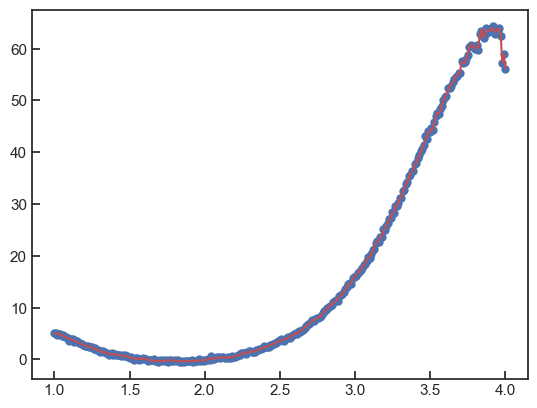

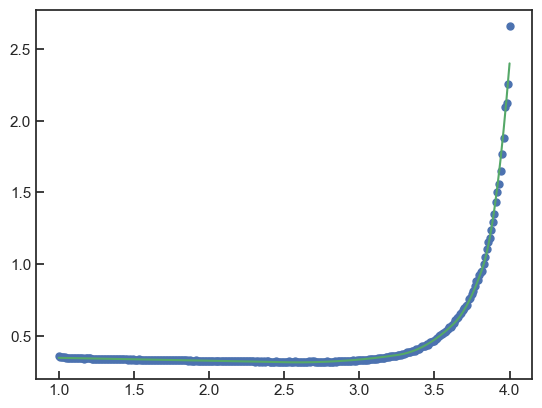

./CalibrationFiles/ChargeampCalibration0.1hzto10000-2.csv
180


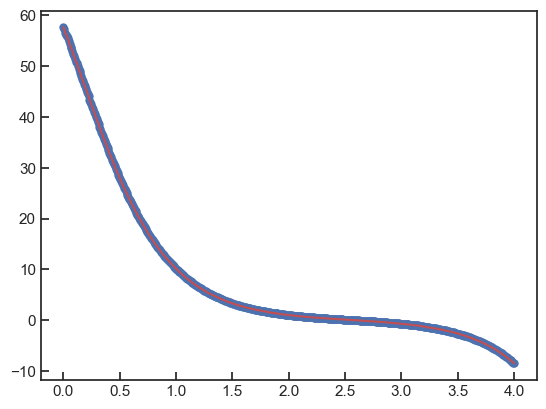

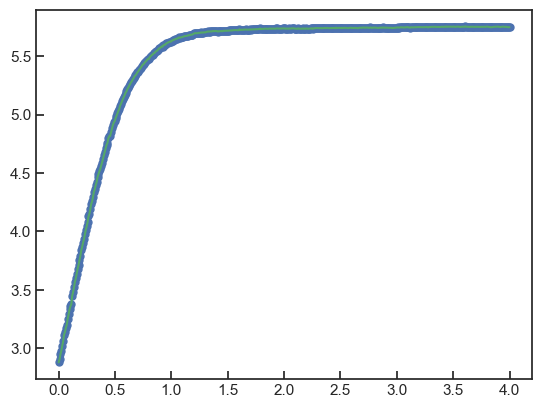

./CalibrationFiles/FullAmptoCharge_SideA_cap.csv
180


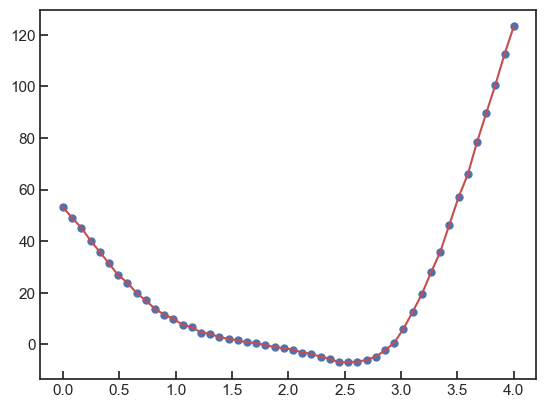

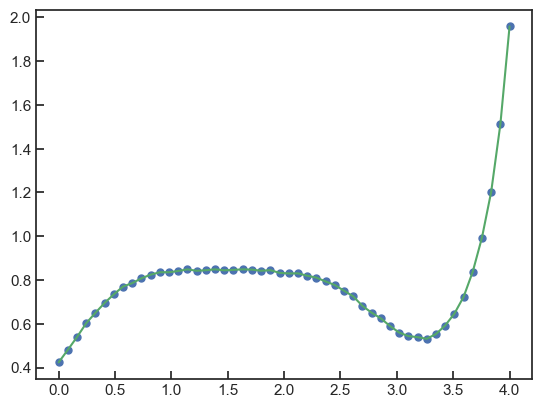

frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
AUTOVOLT
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
10.0


C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


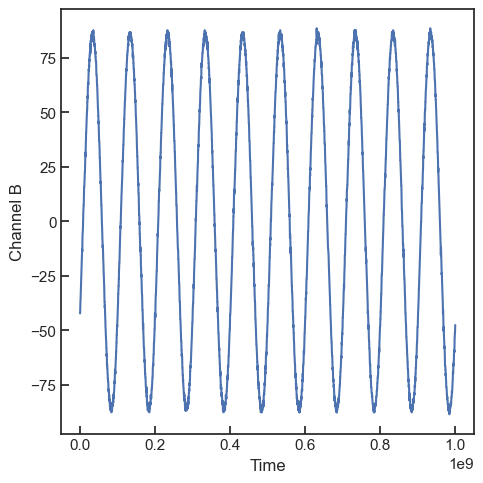

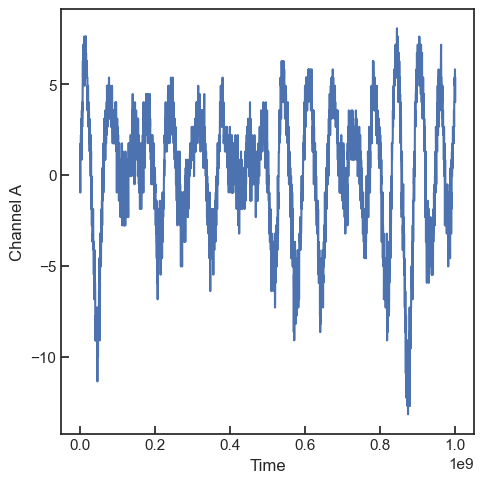

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


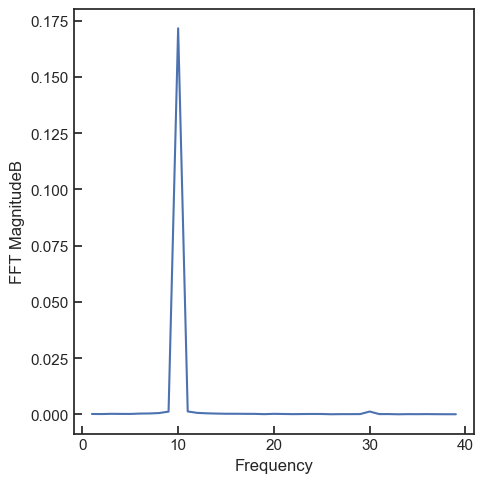

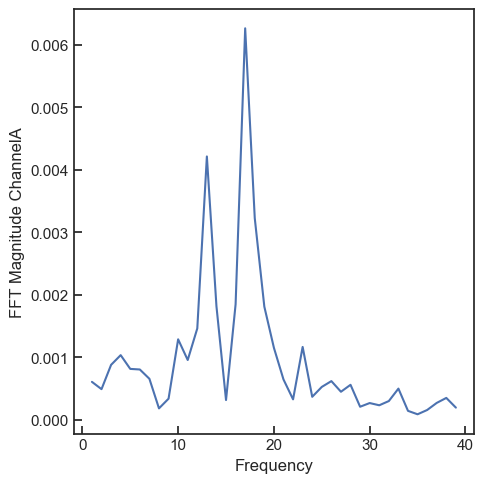

frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 10.0 gain:  1.0006011623633468
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
NO AUTOVOLT
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.00

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


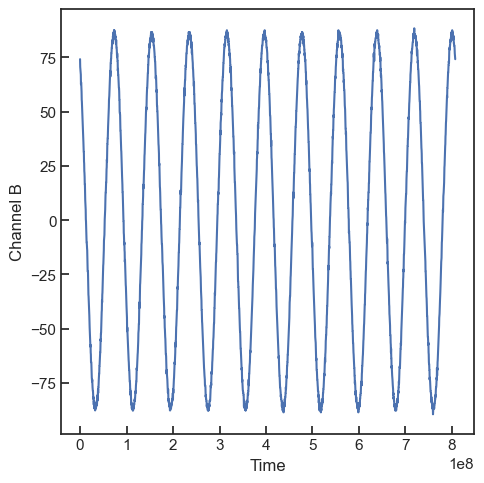

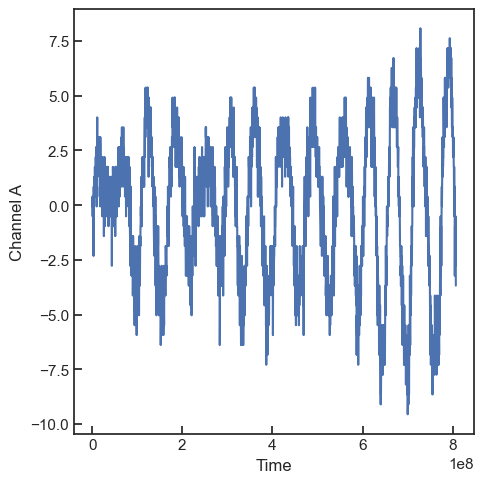

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


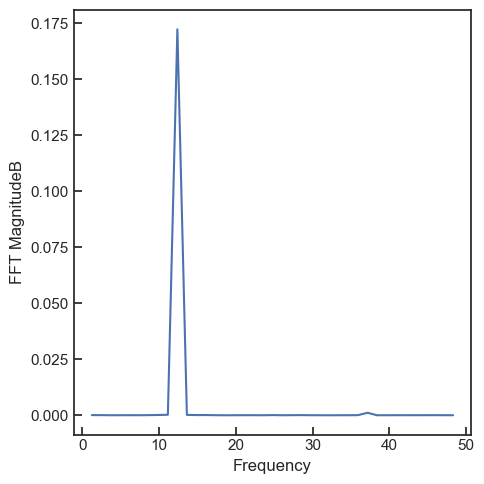

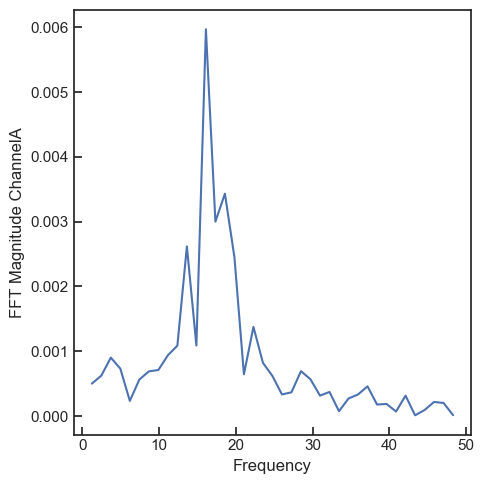

frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 12.389903709420908 gain:  1.000576178053607
frequency: 15.350971392872196 gain:  1.000544499891726
frequency: 15.350971392872196 gain:  1.000544499891726
AUTOVOLT
f

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


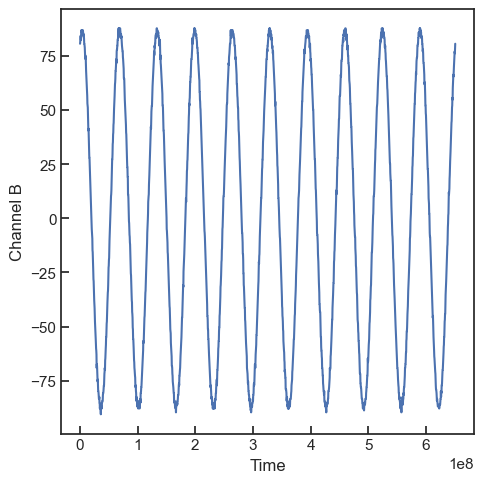

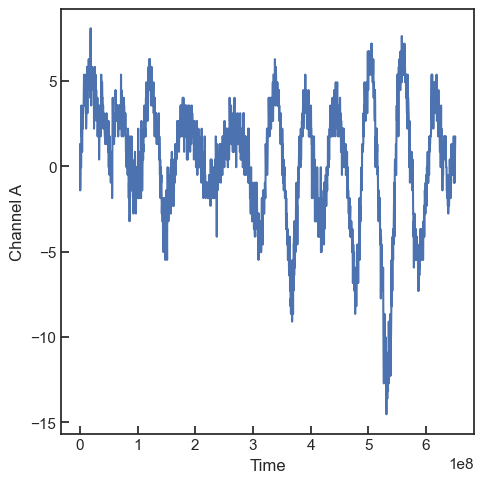

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


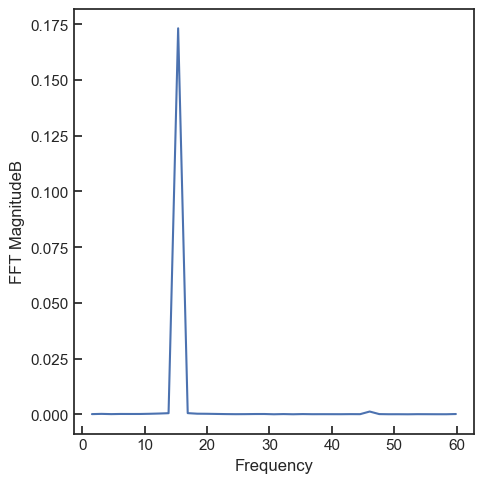

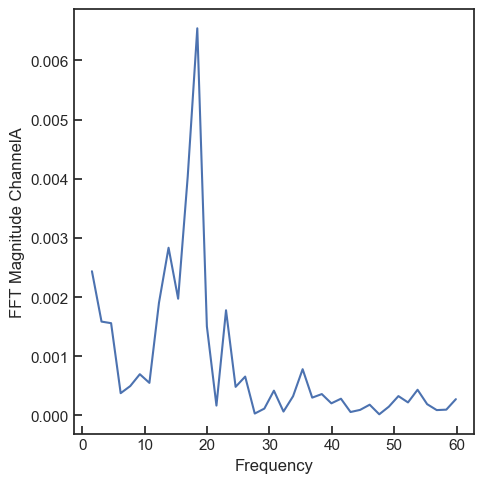

frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
NO AUTOVOLT
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain:  1.0005041471930967
frequency: 19.019705740376157 gain: 

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


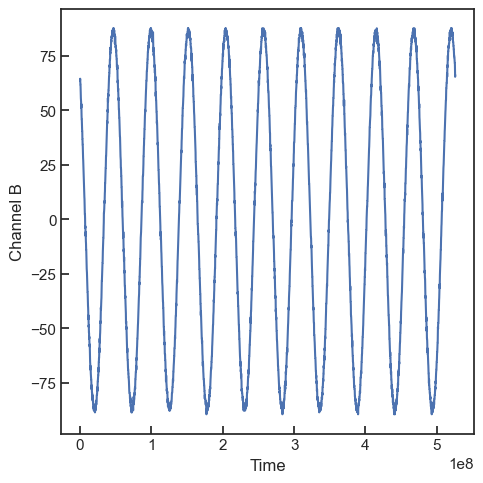

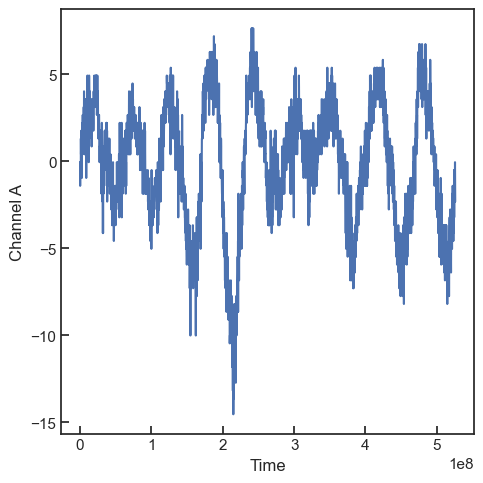

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


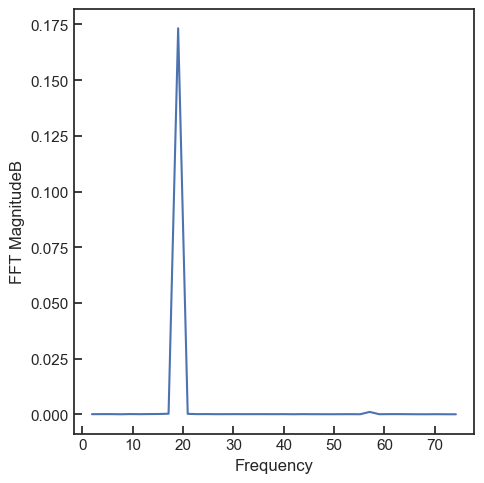

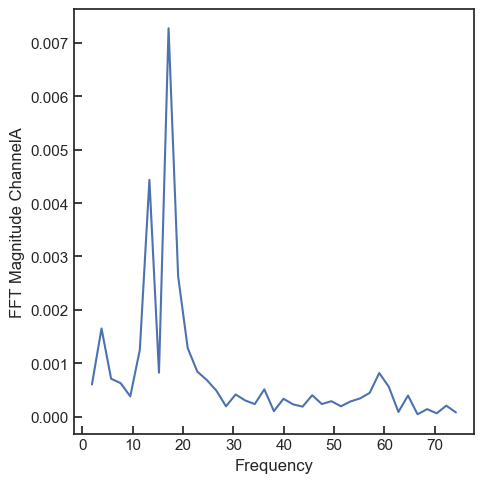

frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
AUTOVOLT
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


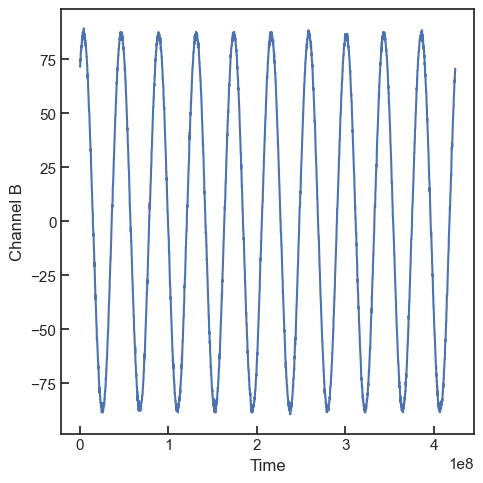

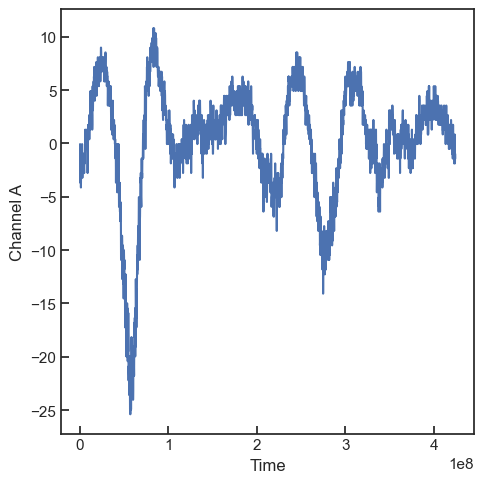

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


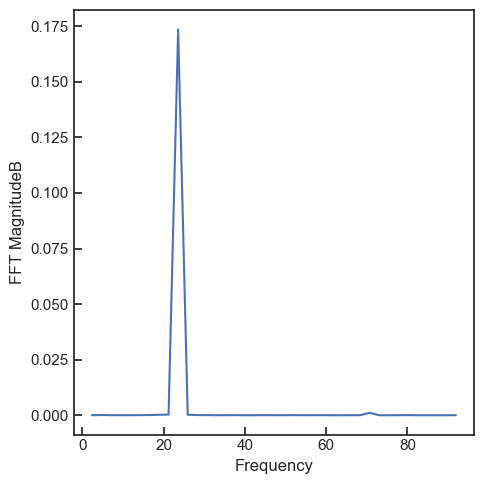

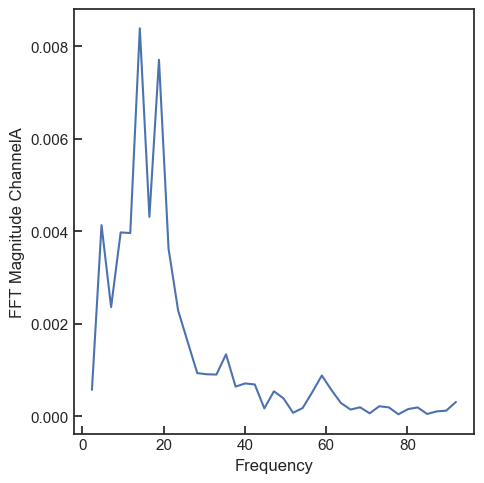

frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 23.565232270478067 gain:  1.0004524673536017
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
NO AUTOVOLT
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain: 

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


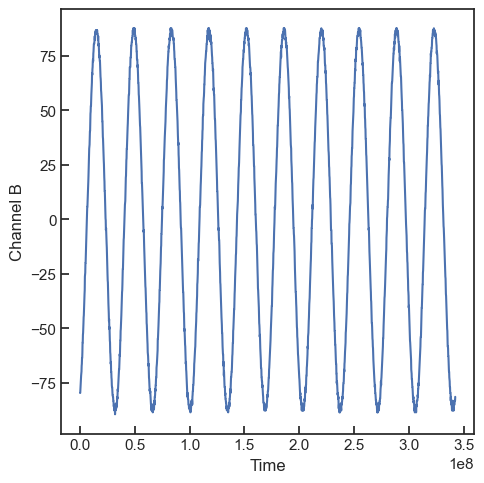

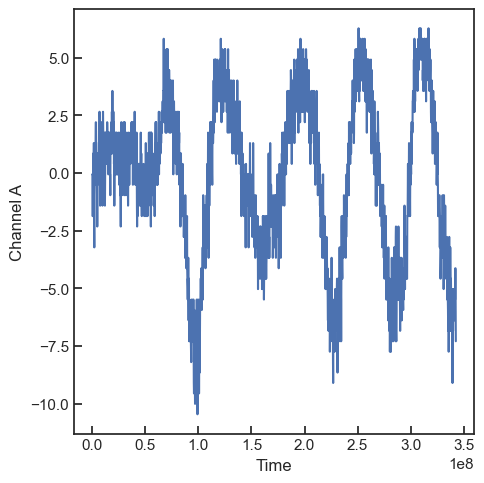

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


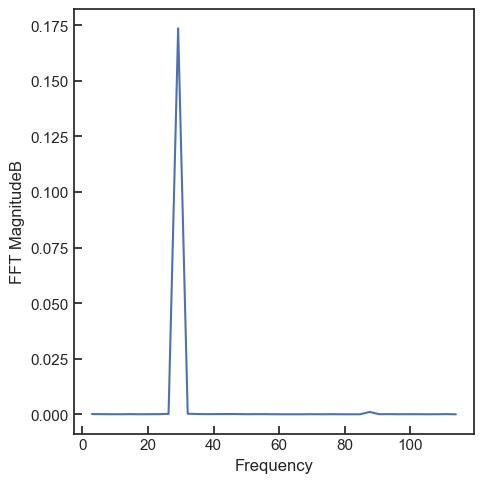

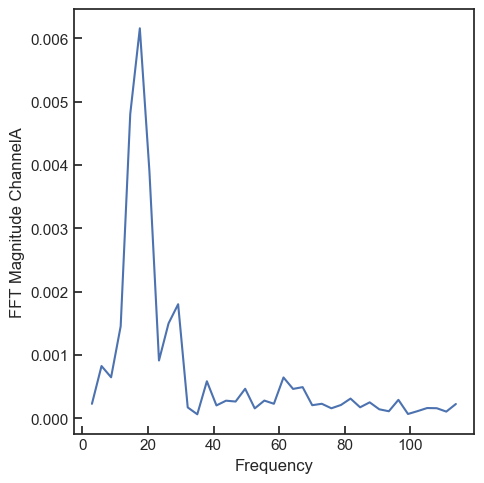

frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 29.197095872136146 gain:  1.0003858737455833
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
AUTOVOLT
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.00029947086741

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


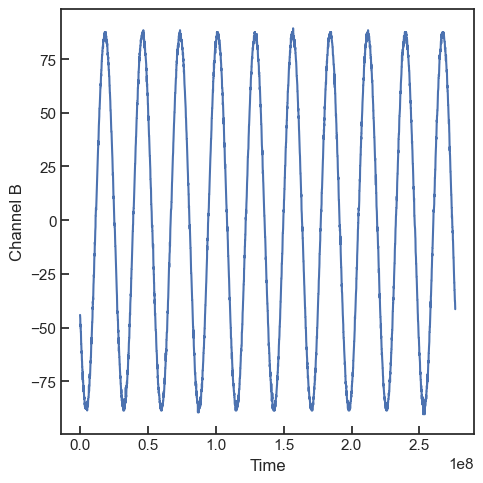

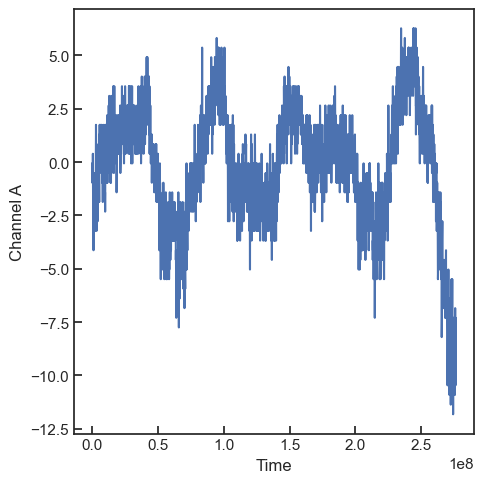

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


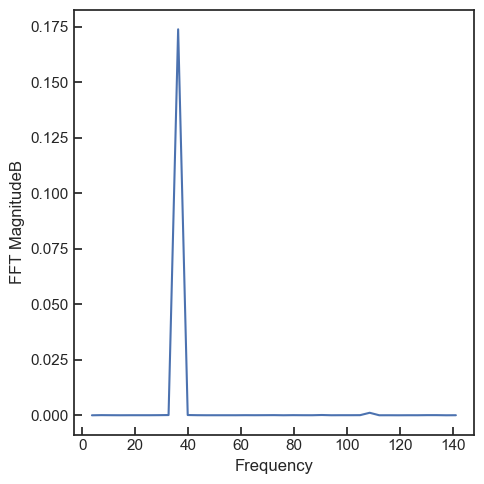

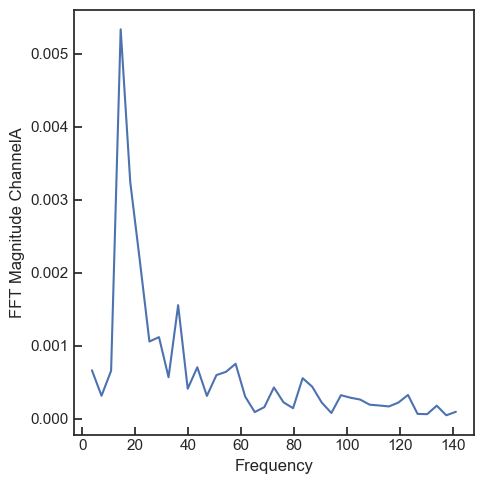

frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 36.17492064504977 gain:  1.0002994708674167
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
NO AUTOVOLT
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.00018

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


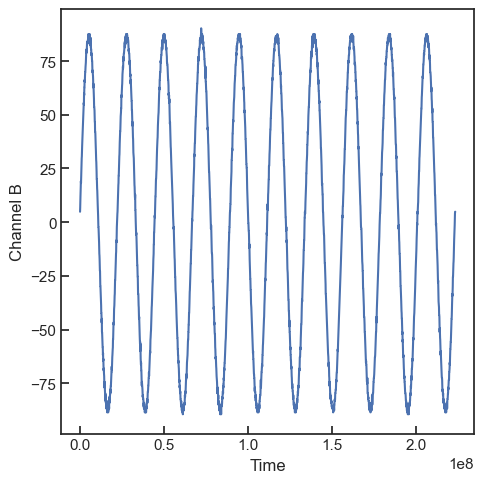

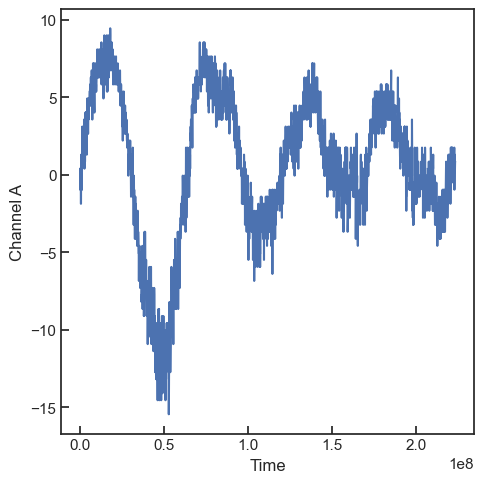

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


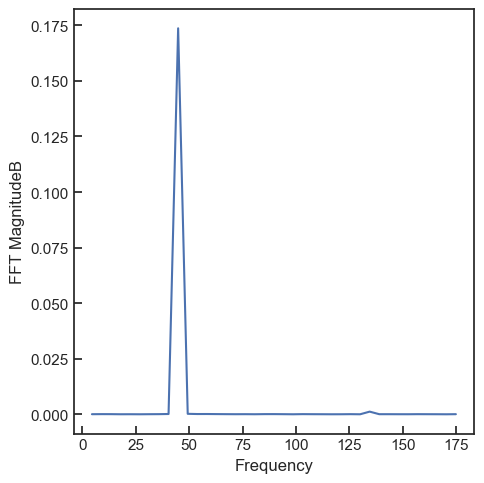

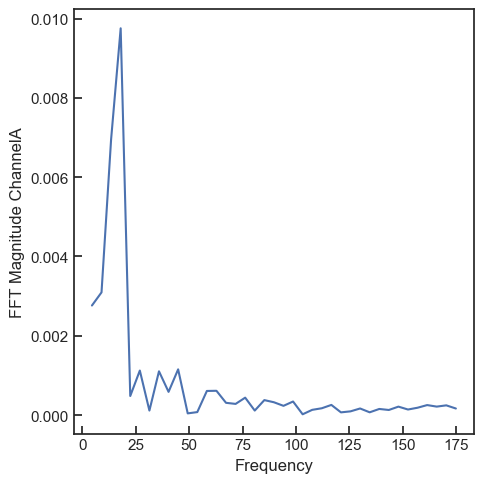

frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 44.820378348810905 gain:  1.0001865167353787
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
AUTOVOLT
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


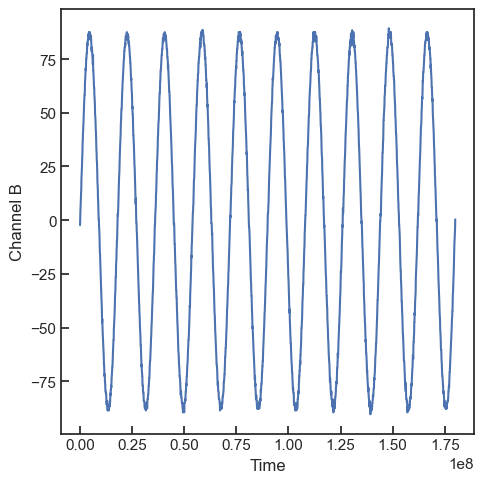

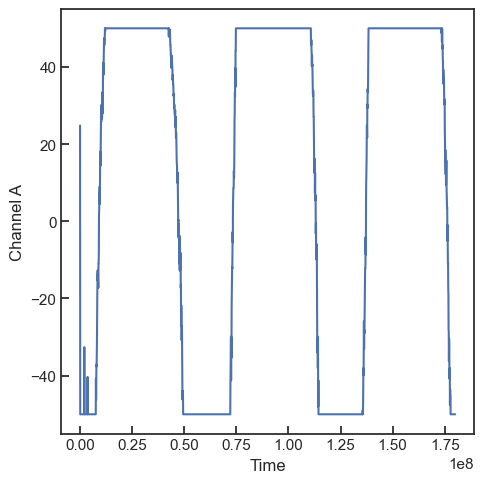

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


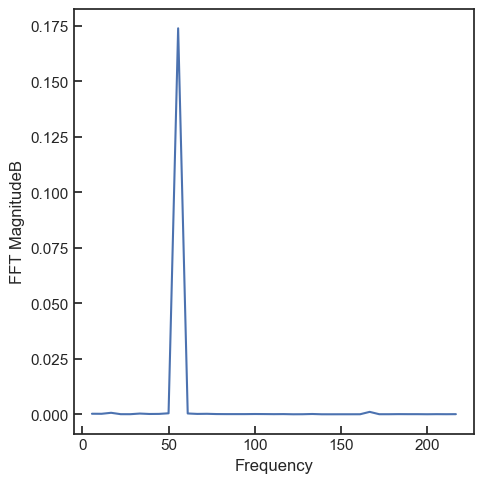

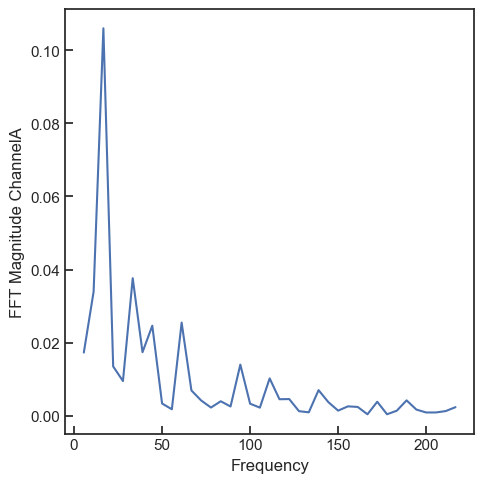

frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 55.53201719615808 gain:  1.0000376515103062
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
NO AUTOVOLT
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.999839793364993

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


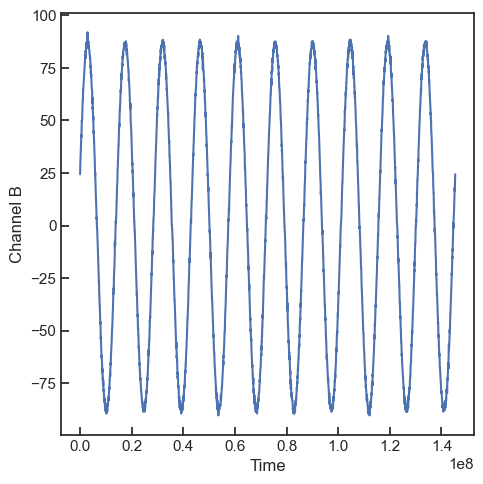

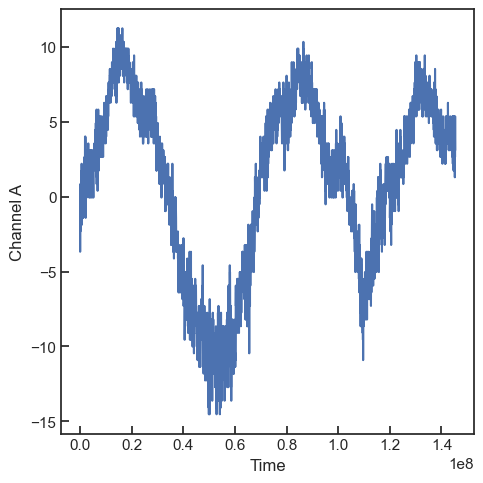

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


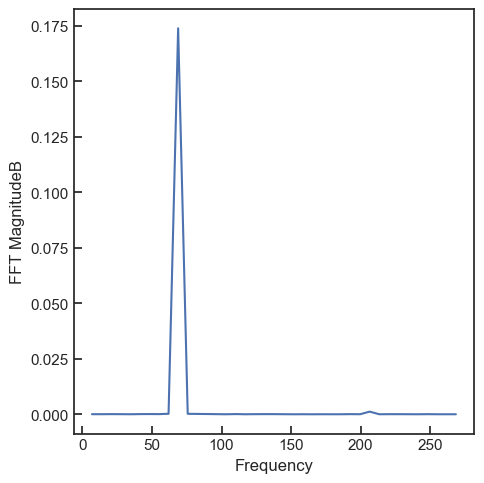

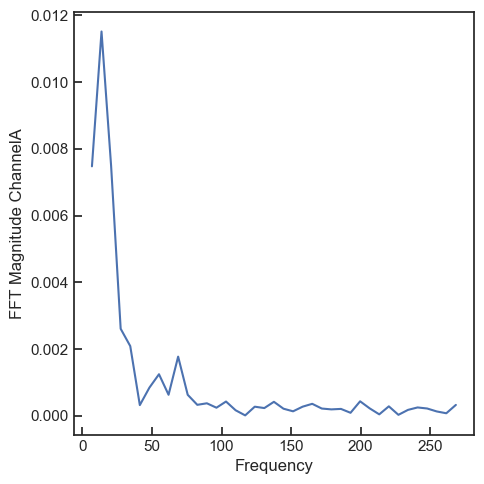

frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 68.80363458503047 gain:  0.9998397933649937
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
AUTOVOLT
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
f

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


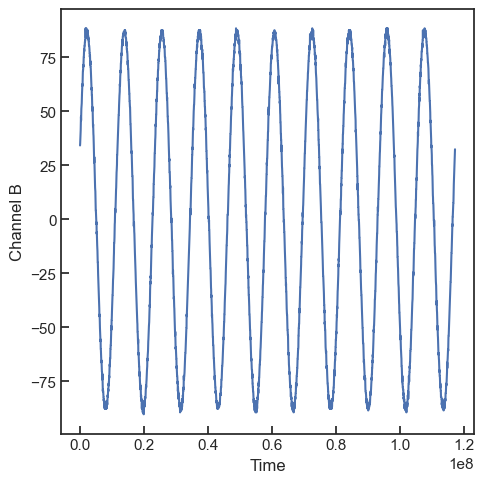

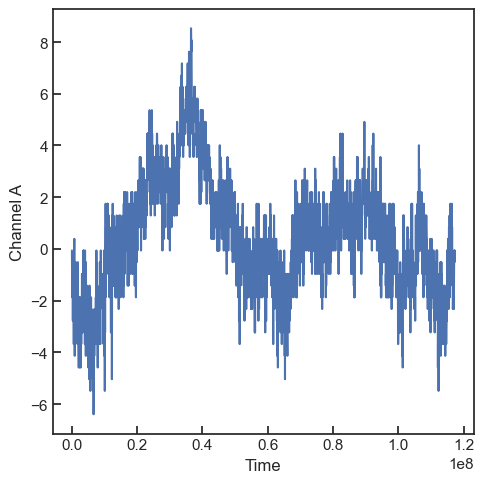

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


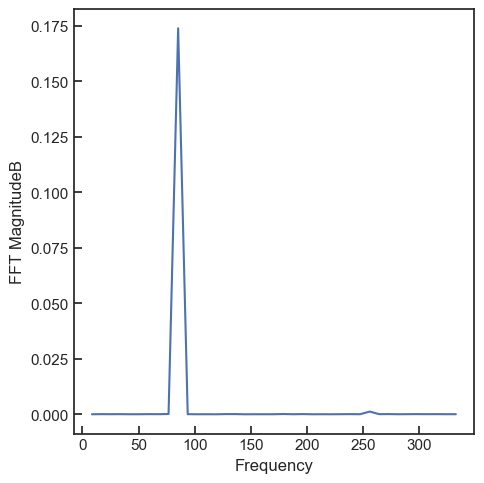

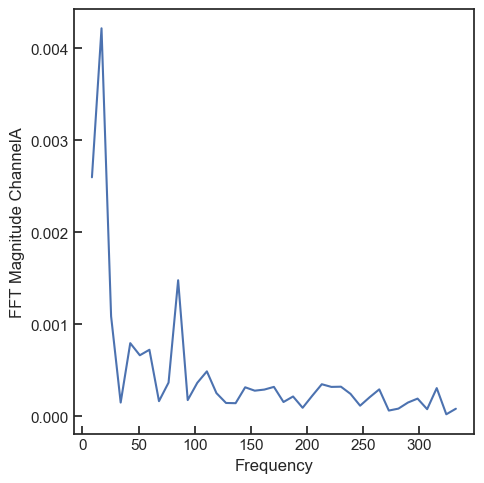

frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 85.24704073667095 gain:  0.9995745673342405
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
NO AUTOV

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


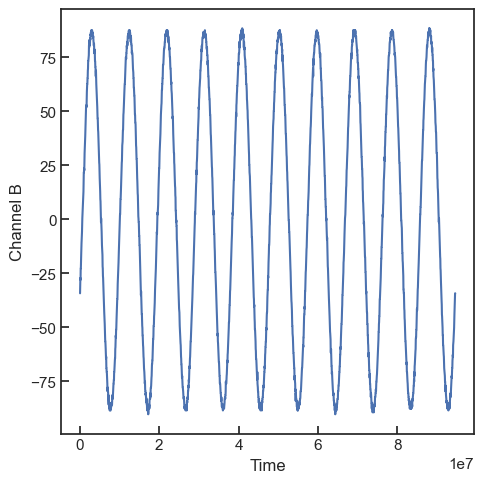

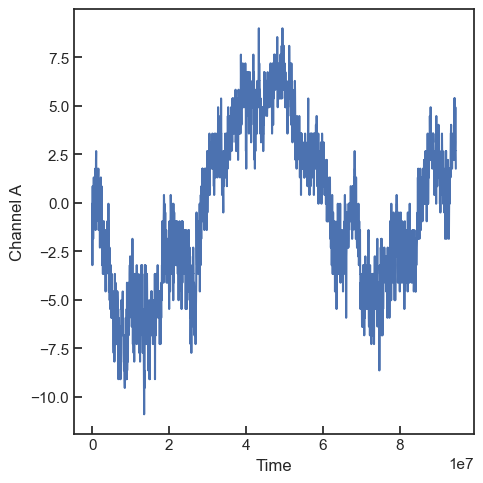

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


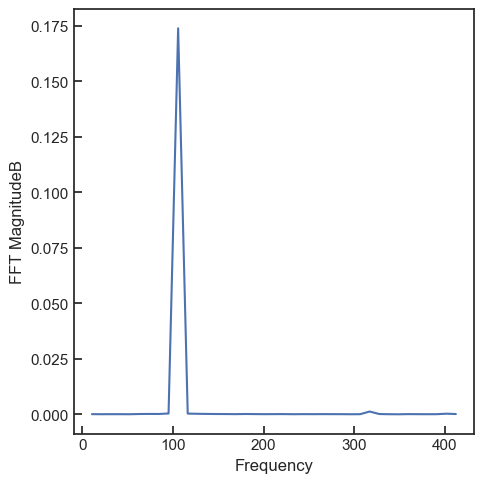

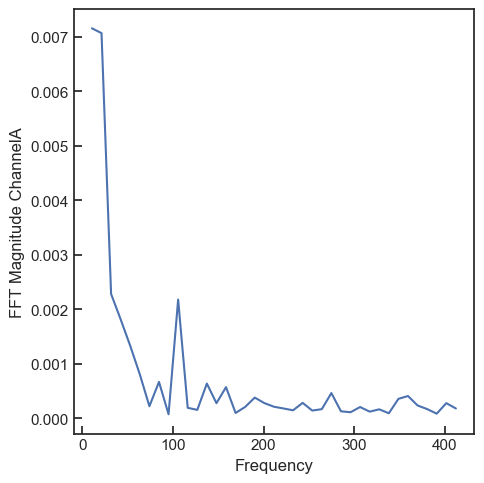

frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 105.62026262404358 gain:  0.9992160927331268
frequency: 130.8624883675648 gain:  0.9987279183773613
frequency: 130.8624883675648 gain:  0.99872791837

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


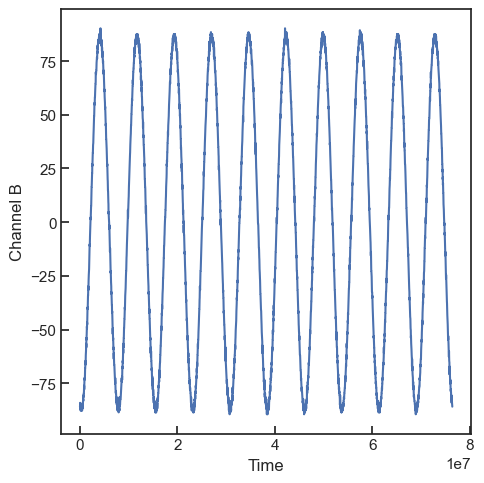

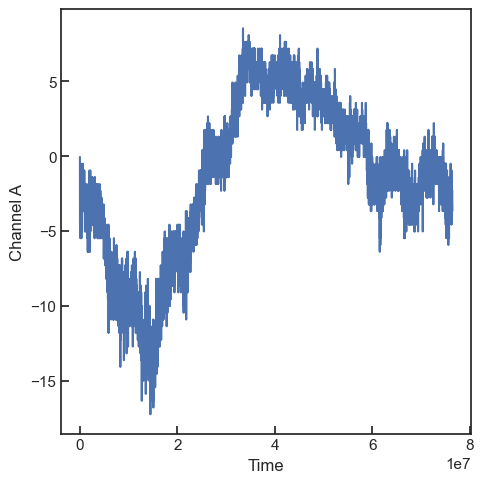

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


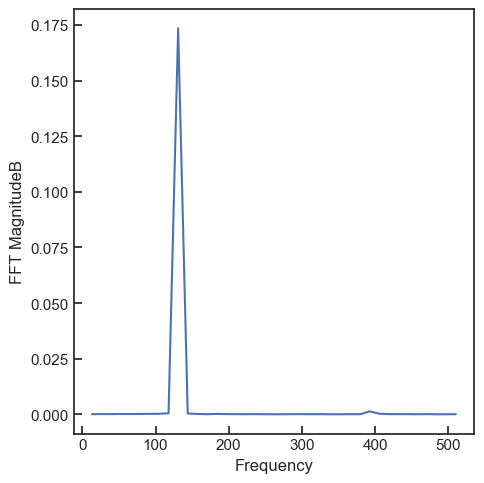

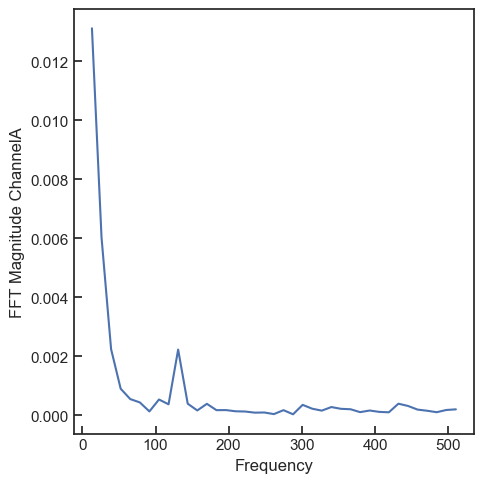

frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
NO AUTOVOLT
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain:  0.9980588844330808
frequency: 162.13736300493414 gain: 

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


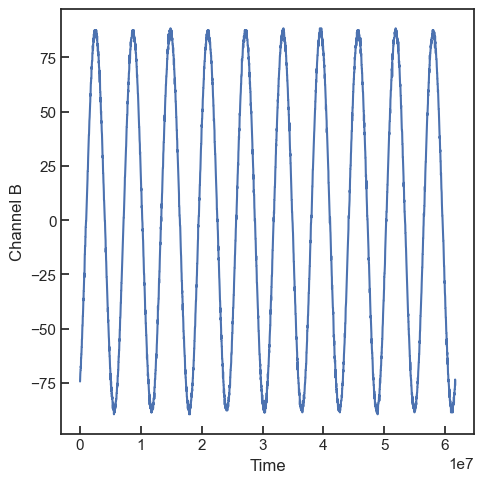

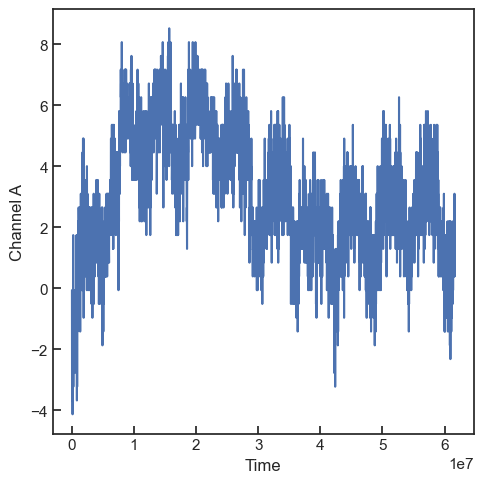

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


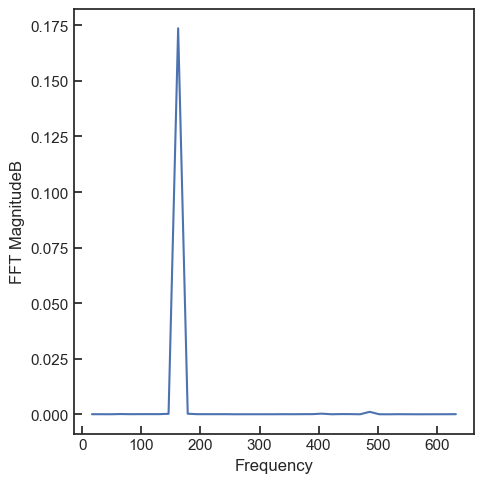

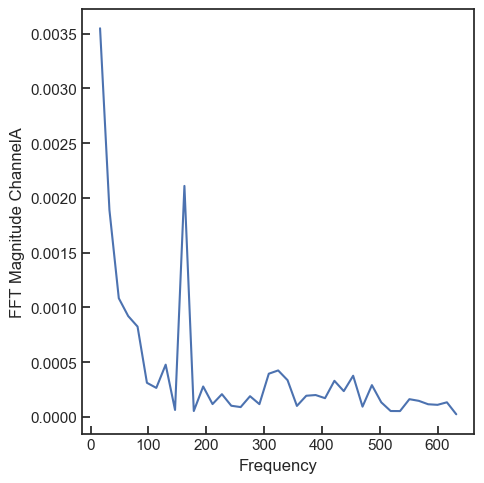

frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
AUTOVOLT
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


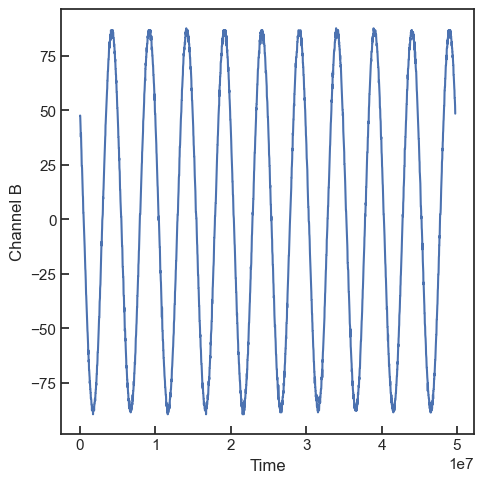

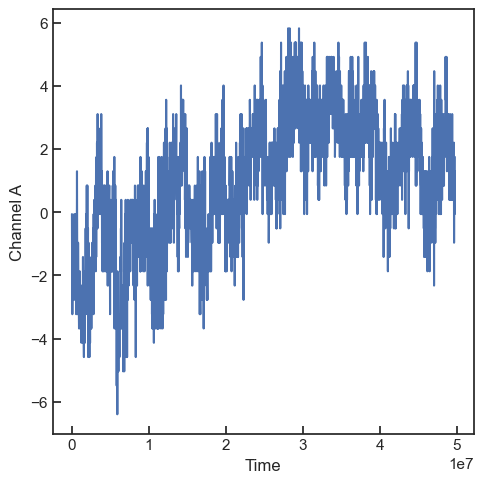

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


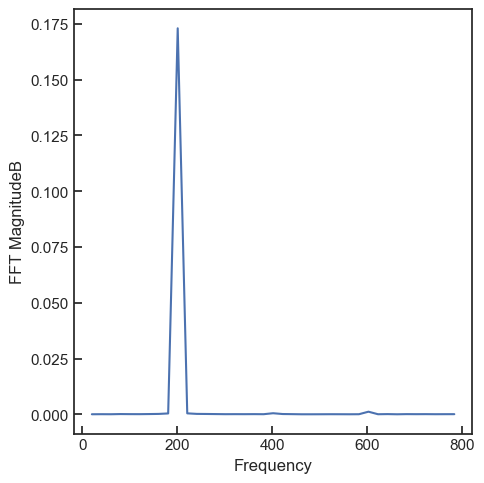

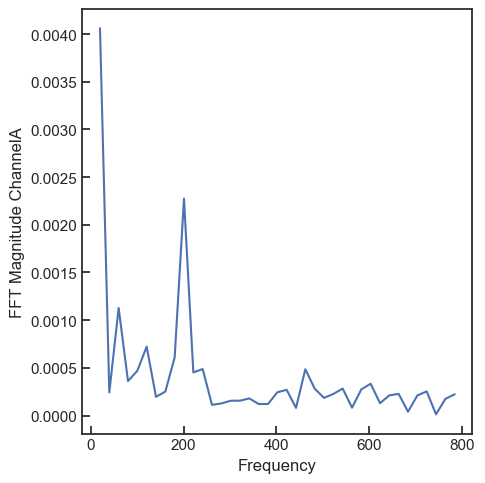

frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 200.88663153305575 gain:  0.9971377541291961
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
NO AUTOVOLT
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.9958666967

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


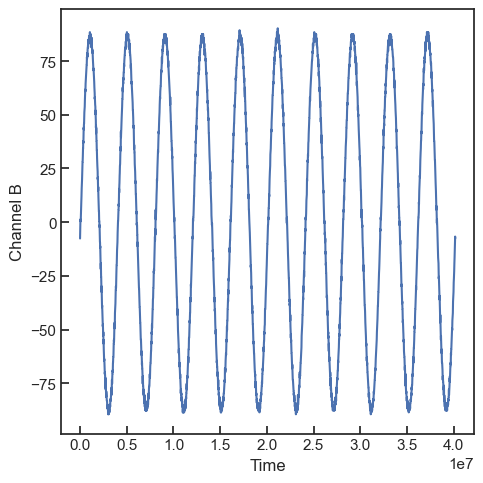

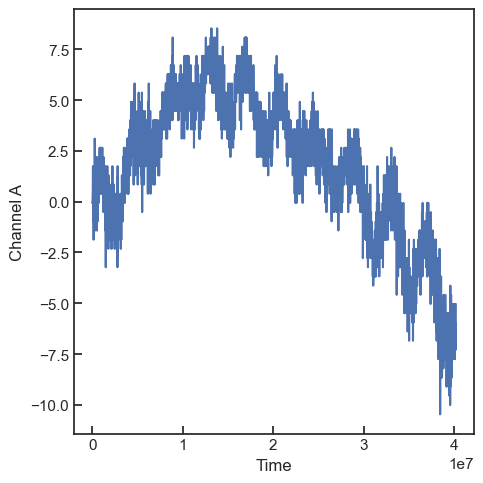

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


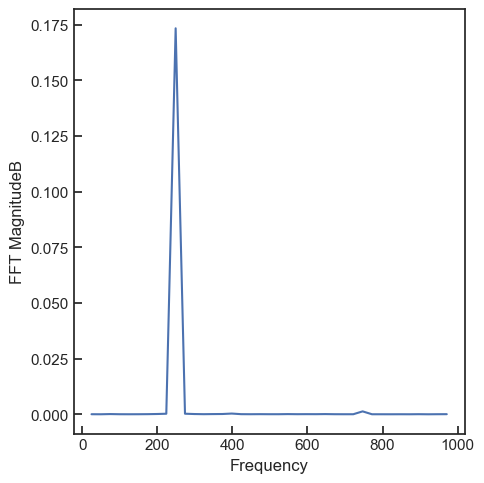

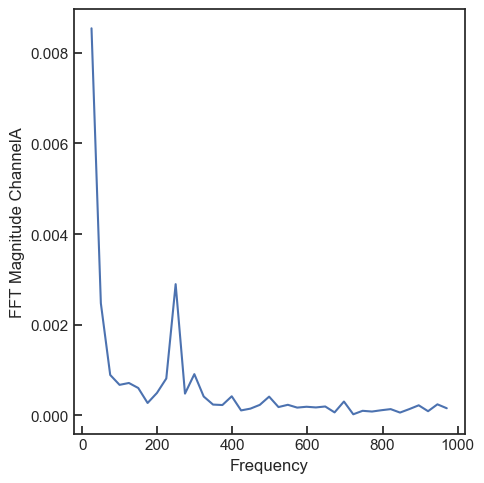

frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 248.89660212044785 gain:  0.995866696782313
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
AUTOVOLT
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
f

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


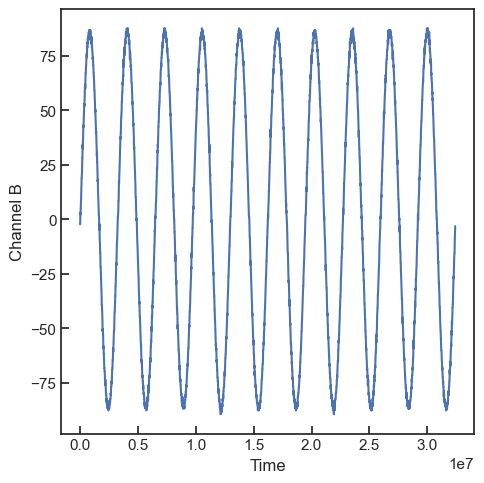

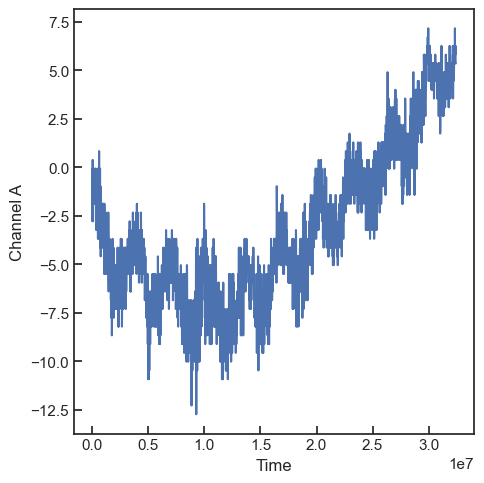

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


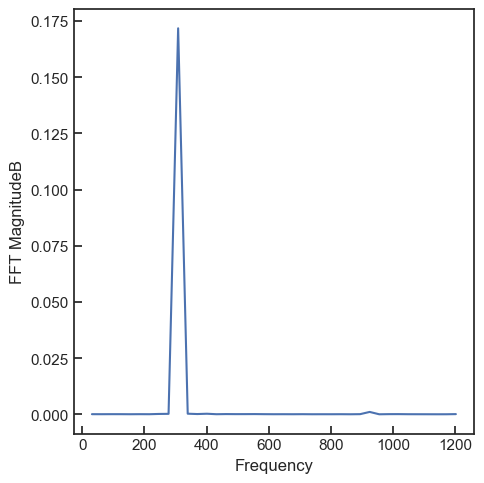

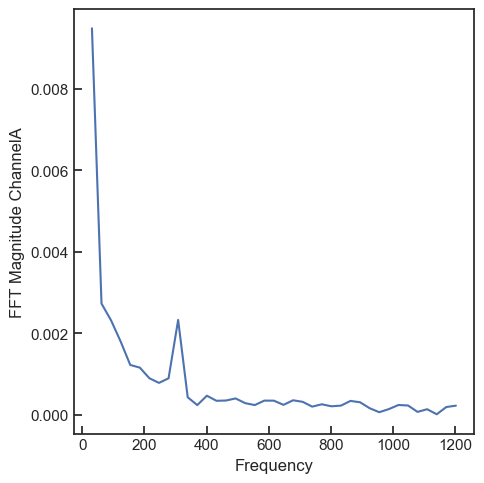

frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 308.3804933874397 gain:  0.9941143030555559
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
NO AUTOVOLT
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.991710105425119

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


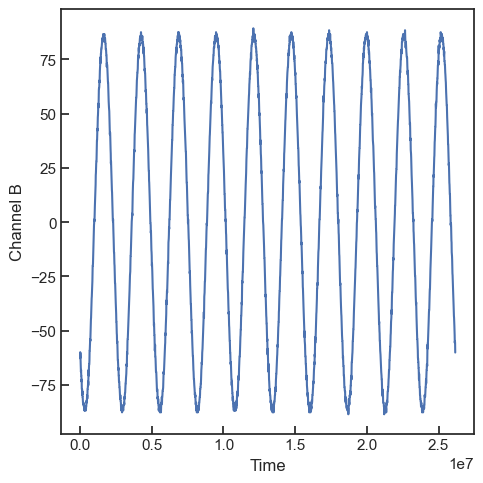

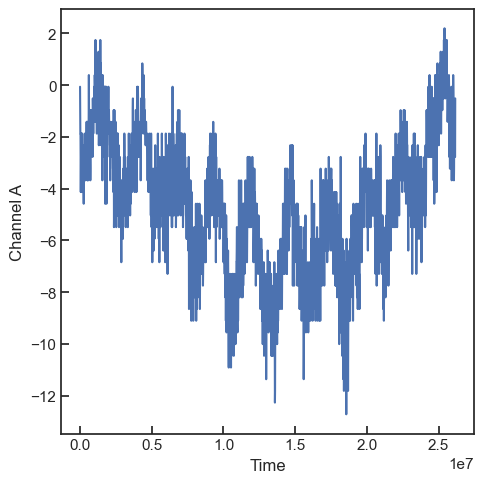

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


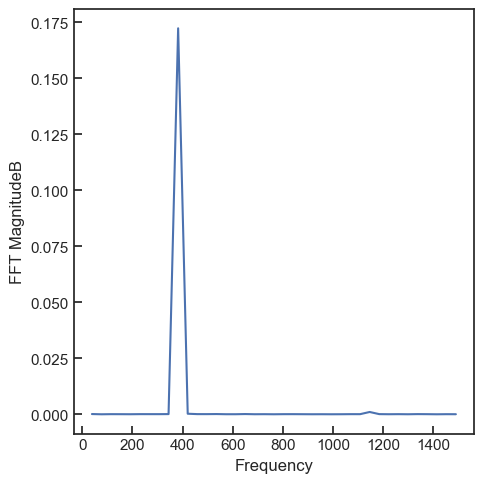

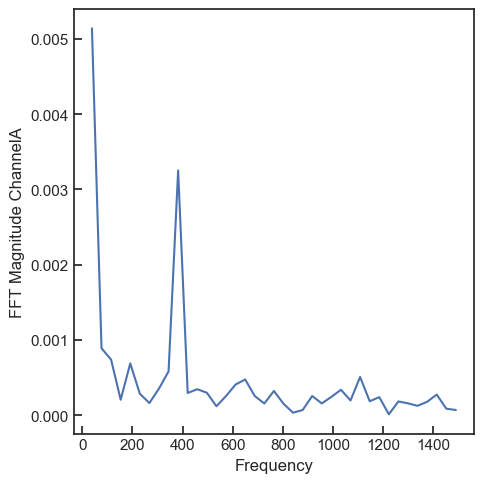

frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 382.0804618934088 gain:  0.9917101054251192
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
AUTOVOLT
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.394013

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


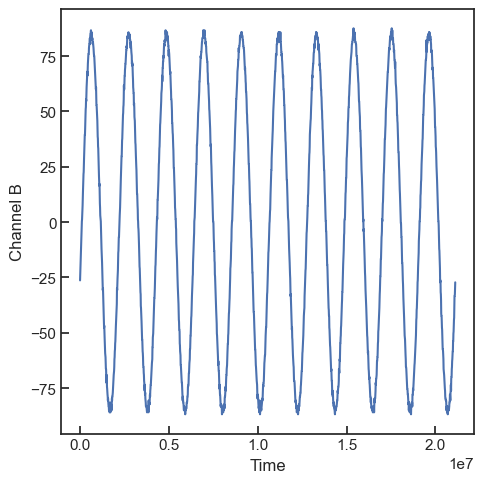

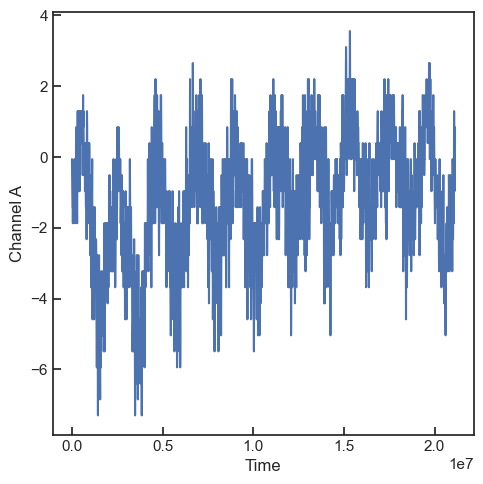

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


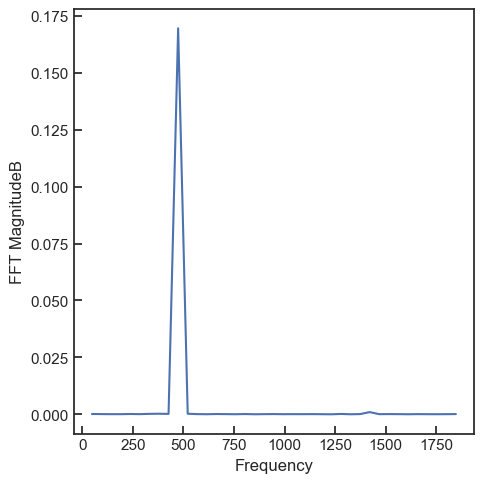

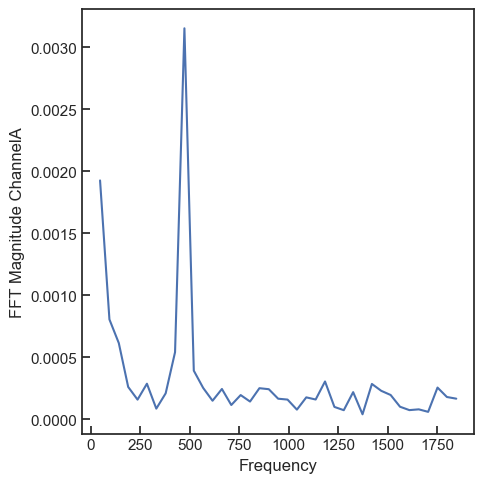

frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 473.39401321104 gain:  0.9884450967389876
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
NO AUTOVOLT
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


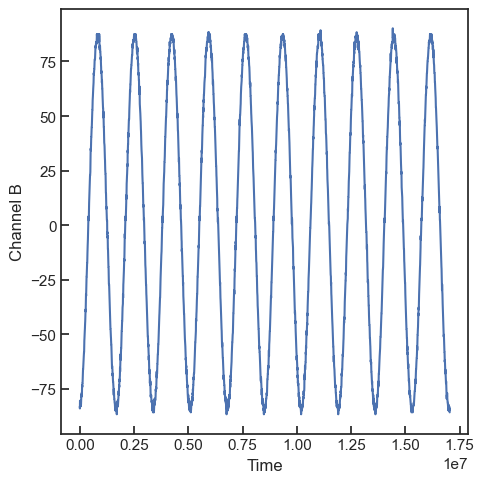

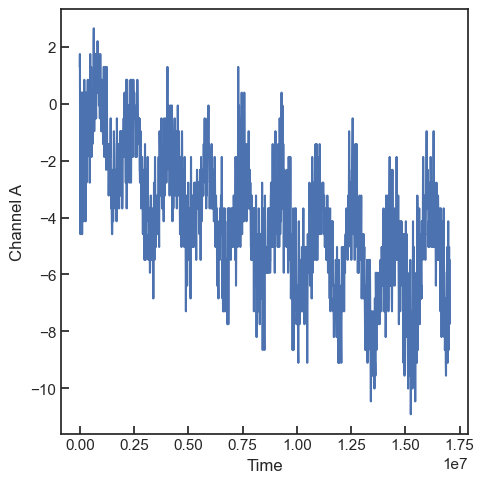

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


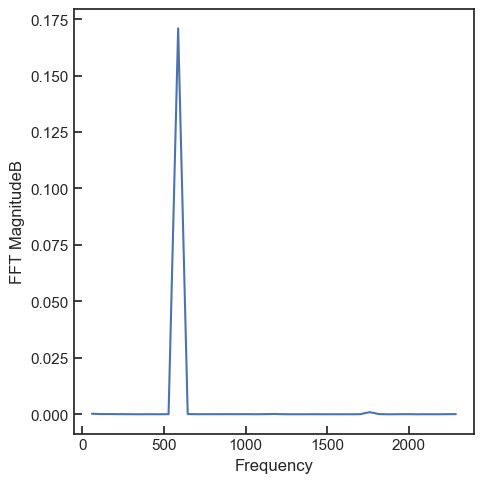

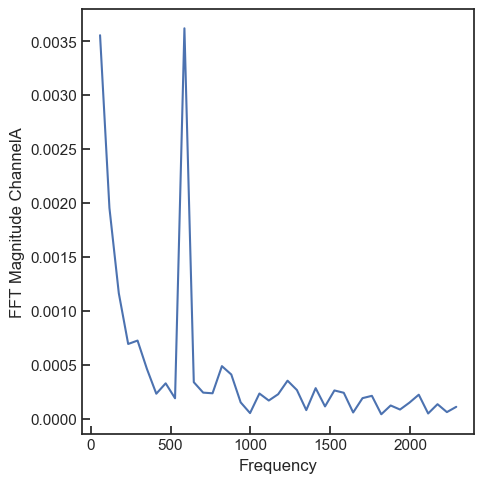

frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 586.5306240301114 gain:  0.9840872274495719
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
AUTOVOLT
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
f

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


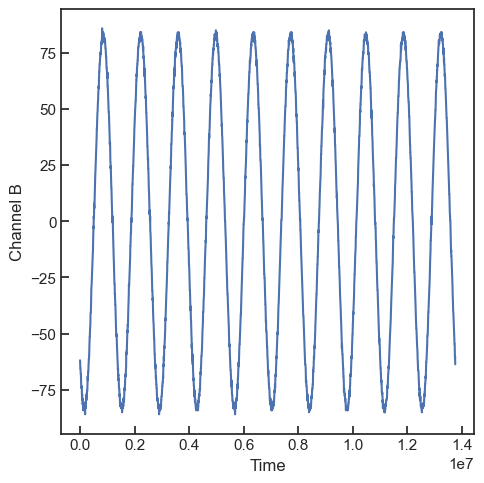

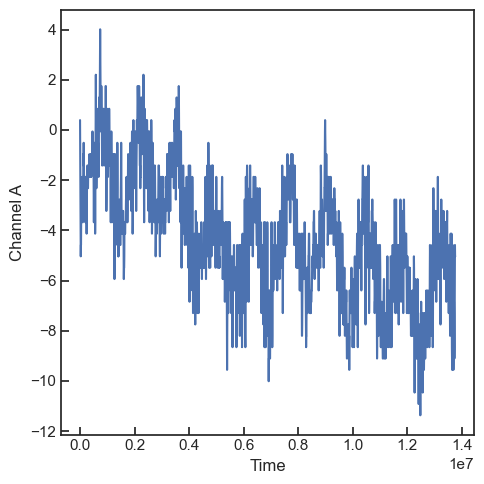

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


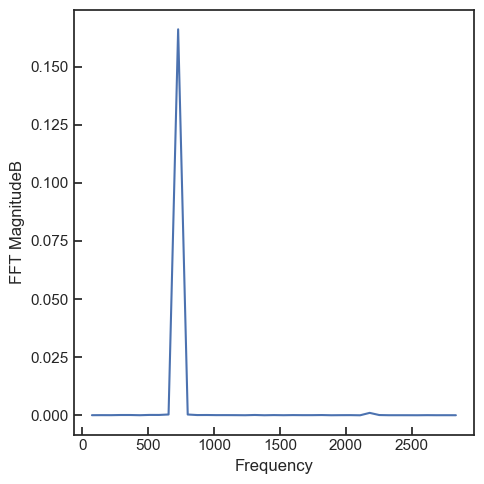

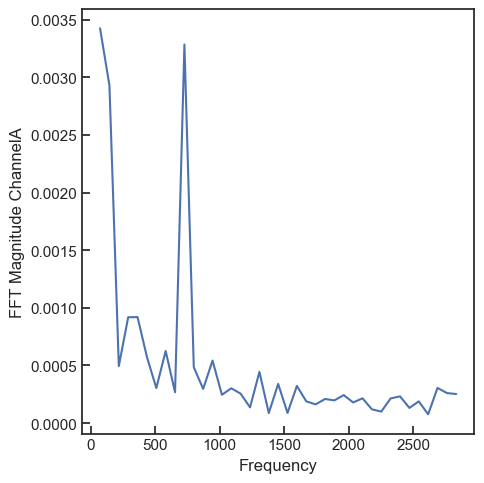

frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 726.7057954359636 gain:  0.9784279857898841
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
NO AUTOVOLT


C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


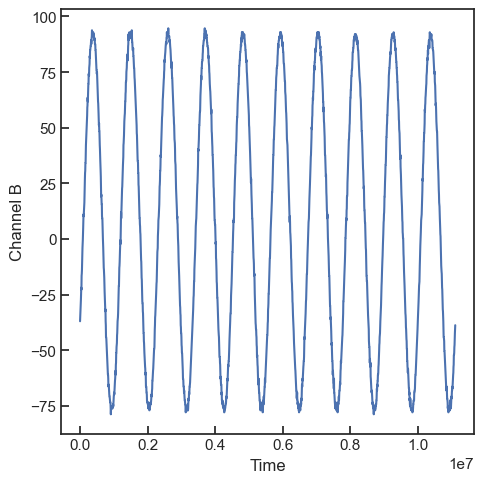

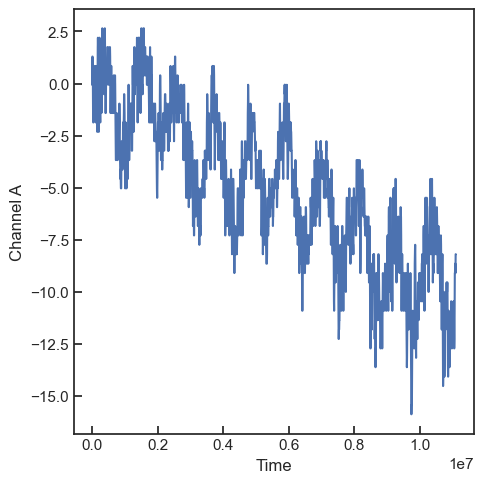

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


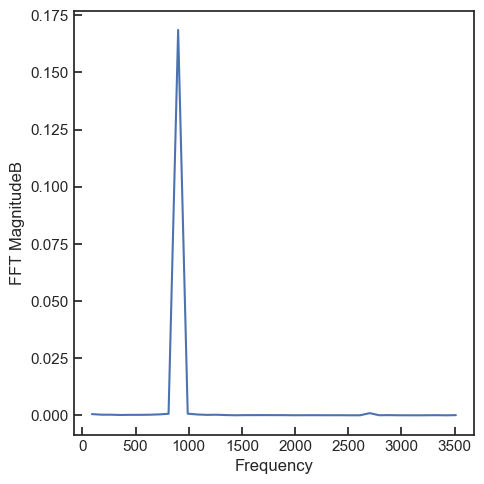

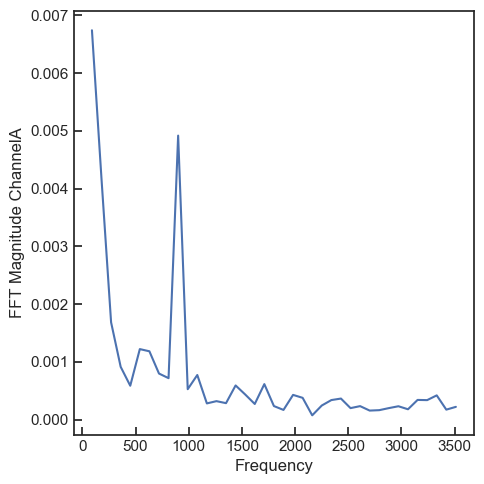

frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 900.3814830529718 gain:  0.971385325661036
frequency: 1115.5639876771925 gain:  0.9631936608666858
frequency: 1115.5639876771925 gain:  0.9631936608666858
AUTOVOLT
frequency: 1115

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


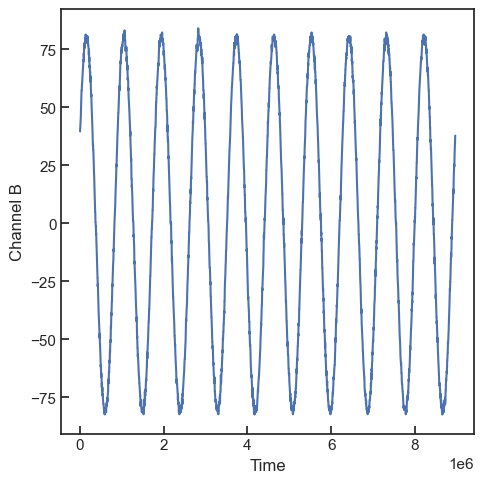

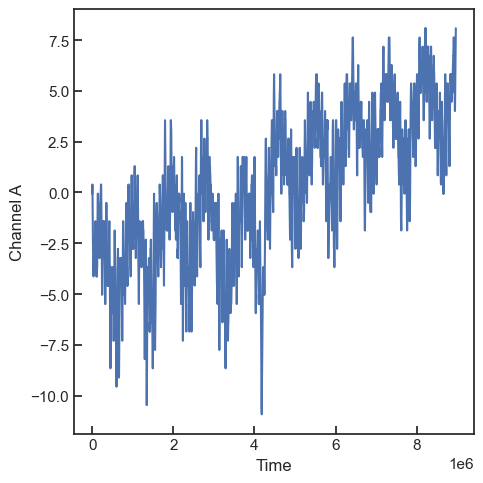

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


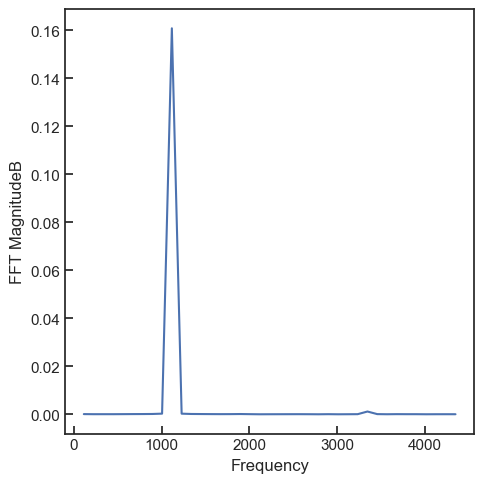

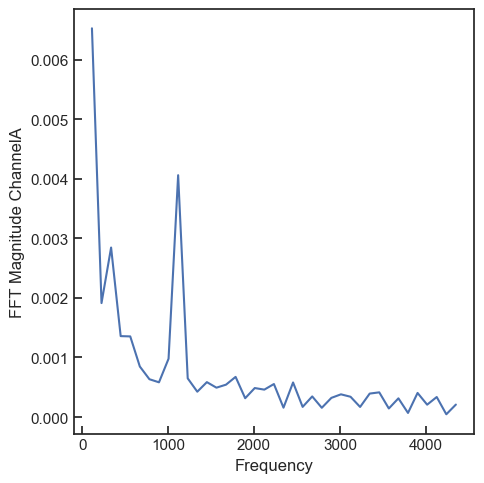

frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
NO AUTOVOLT
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain:  0.9546913165264672
frequency: 1382.1730389018026 gain: 

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


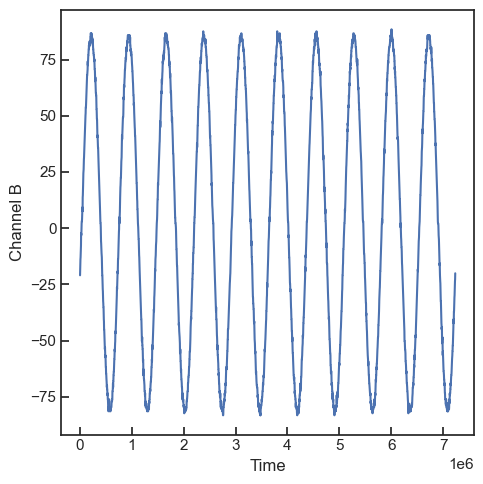

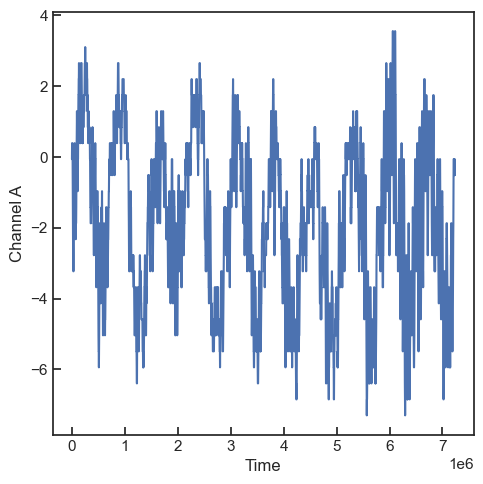

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


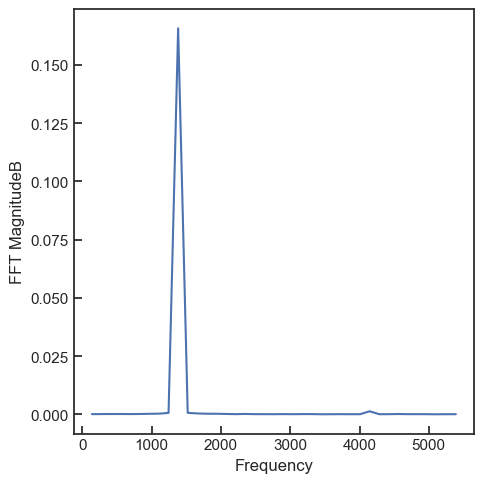

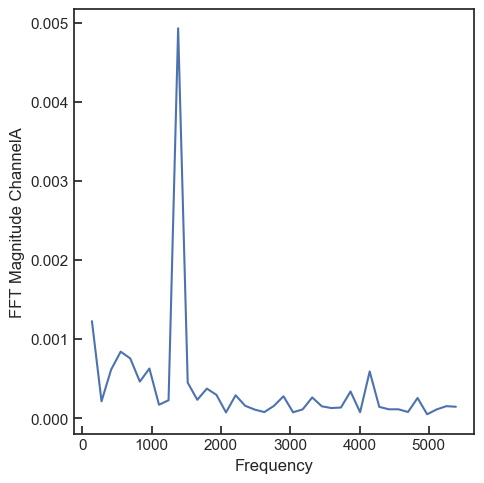

frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
AUTOVOLT
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


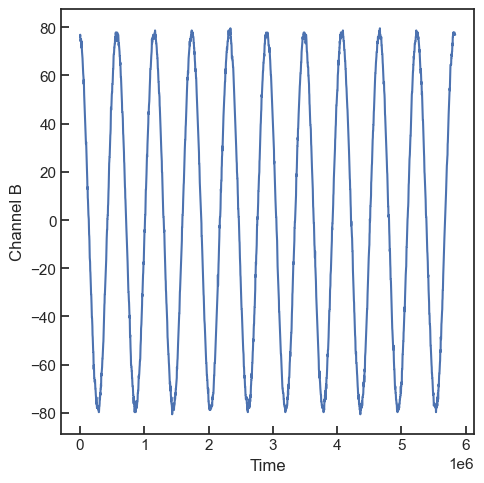

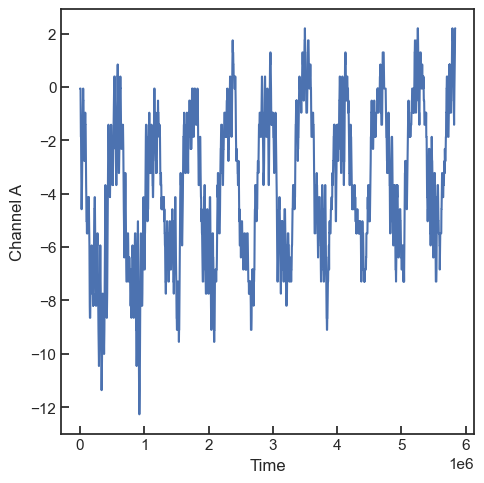

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


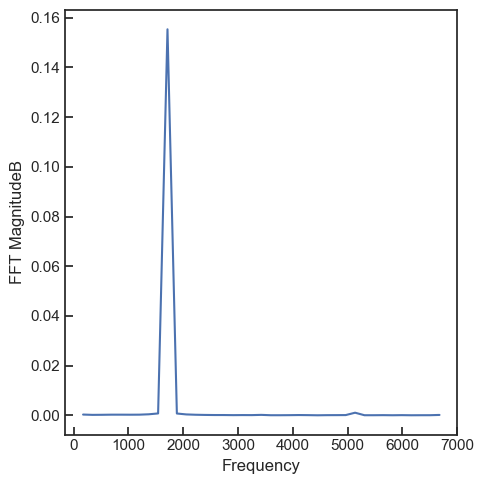

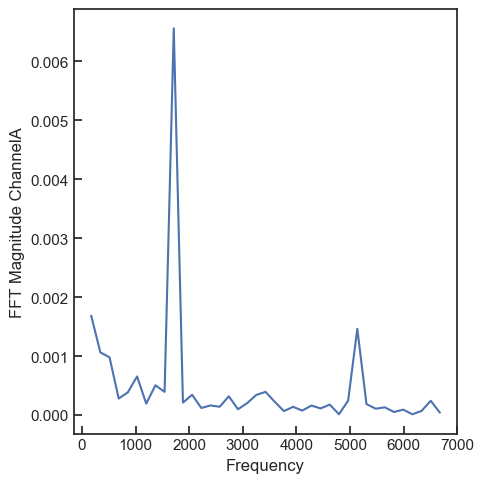

frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 1712.4990861751012 gain:  0.9476009911686062
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
NO AUTOVOLT
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequenc

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


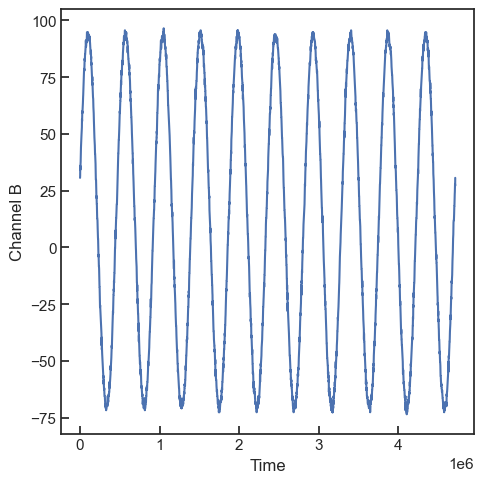

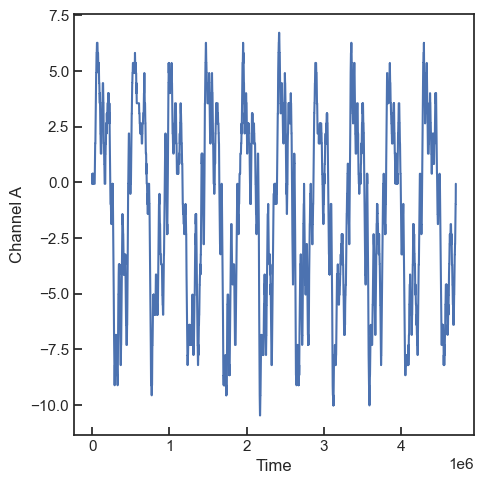

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


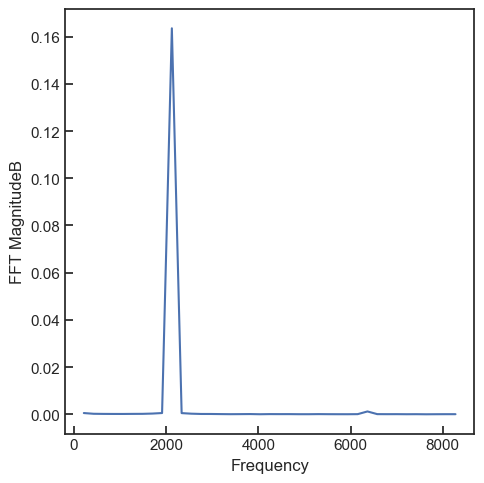

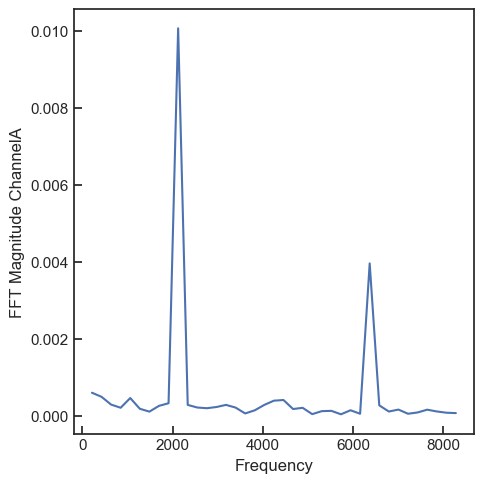

frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2121.76987801808 gain:  0.9429859422067955
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
AUTOVOLT
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.94024083

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


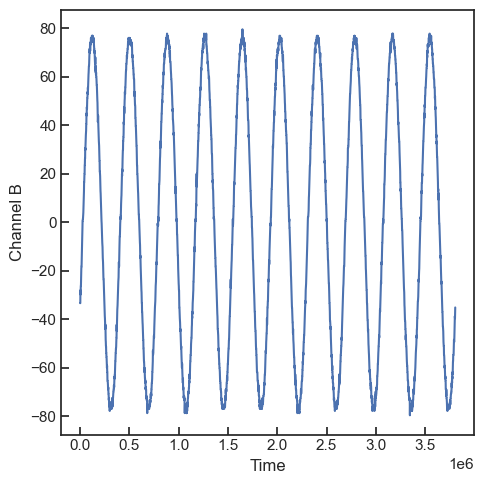

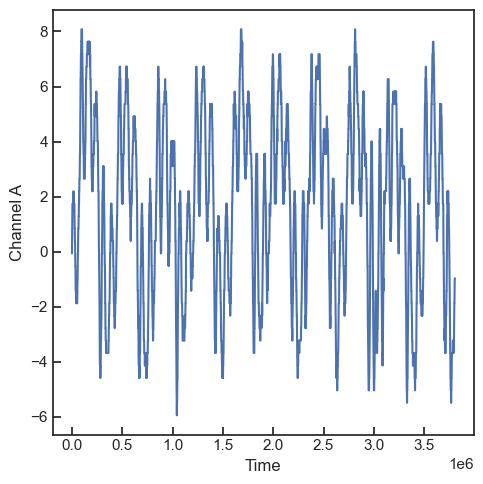

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


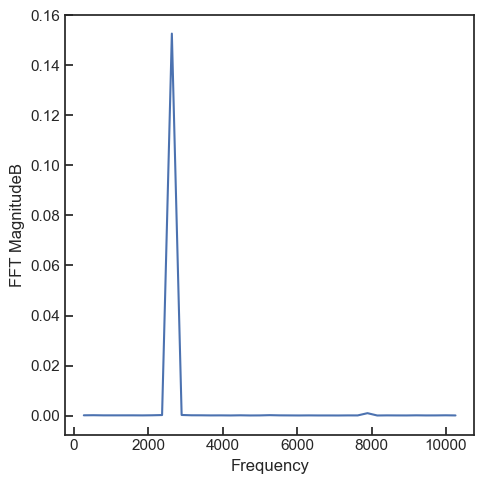

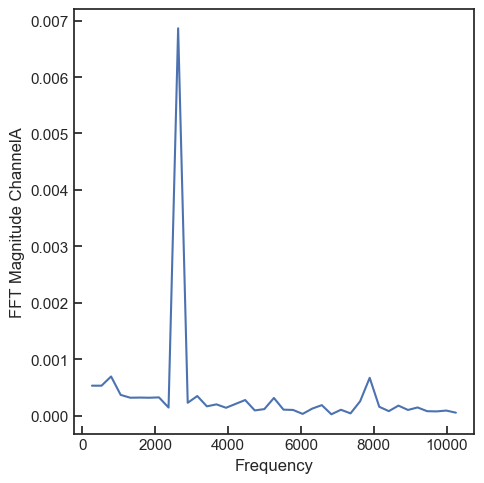

frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 2628.8524482193757 gain:  0.9402408383965454
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
NO AUTOVOLT
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain: 

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


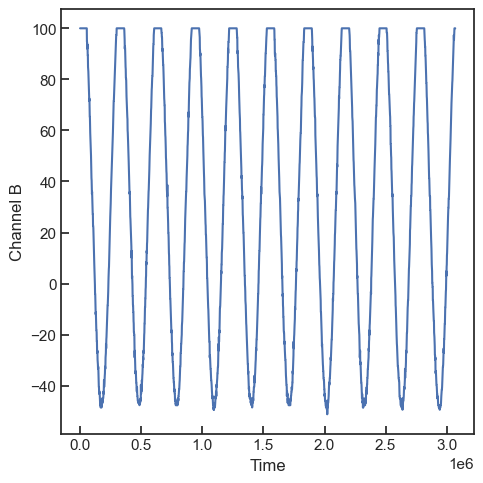

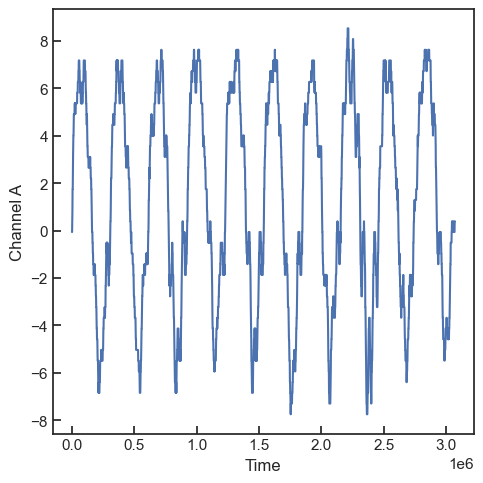

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


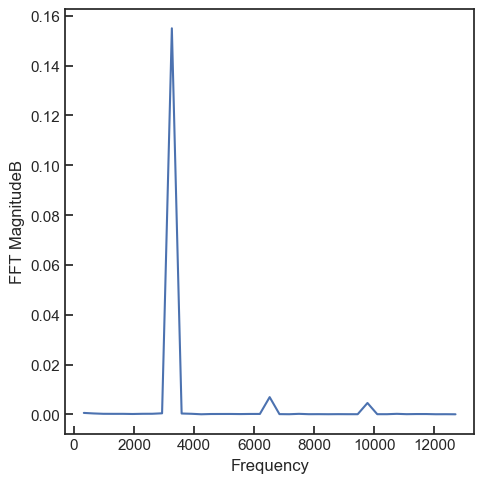

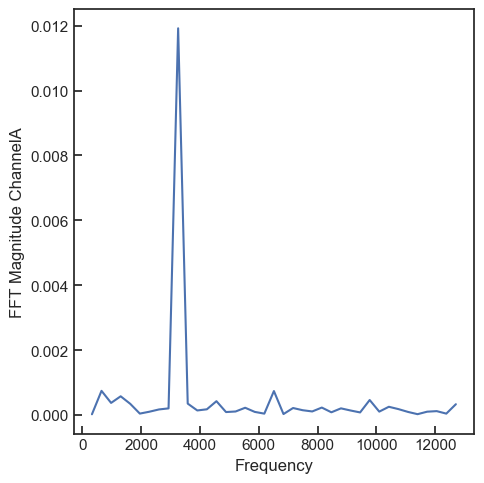

frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 3257.1228699713474 gain:  0.9399350071940159
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
AUTOVOLT
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


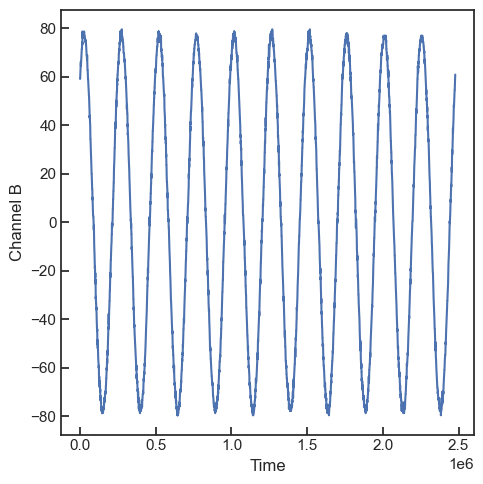

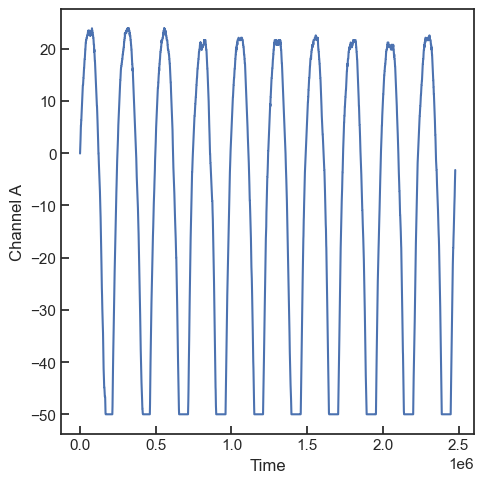

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


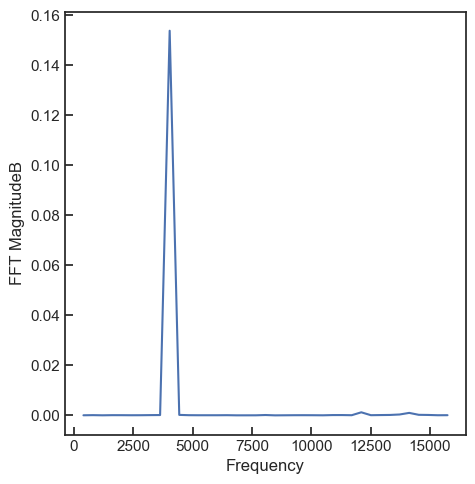

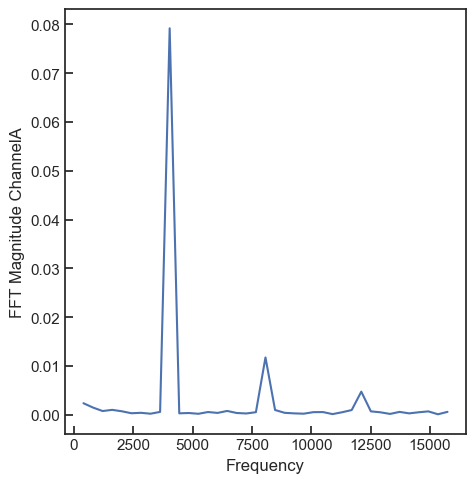

frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4035.5438728697713 gain:  0.9431851483248405
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
NO AUTOVOLT
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.951

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:447: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:450: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


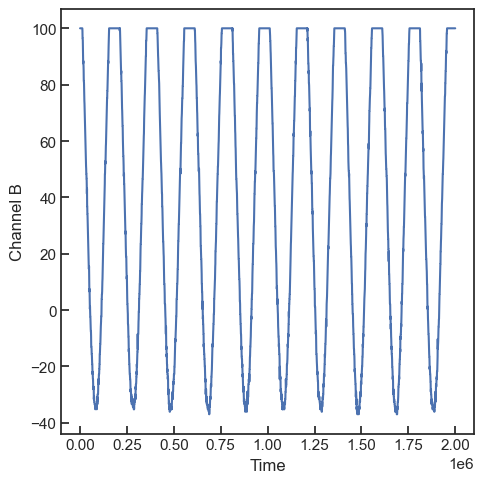

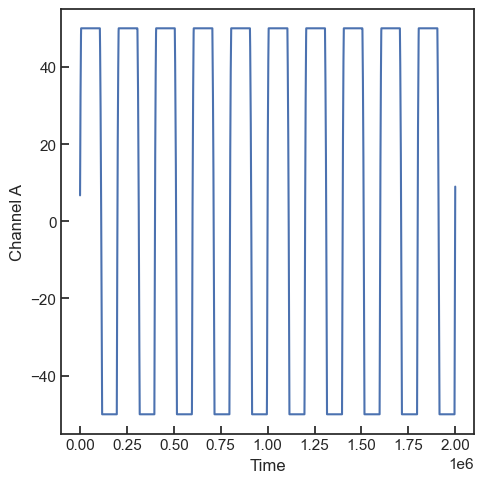

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:463: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a3 = sns.relplot(kind = "line",
C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1123903026.py:467: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a4 = sns.relplot(kind = "line",


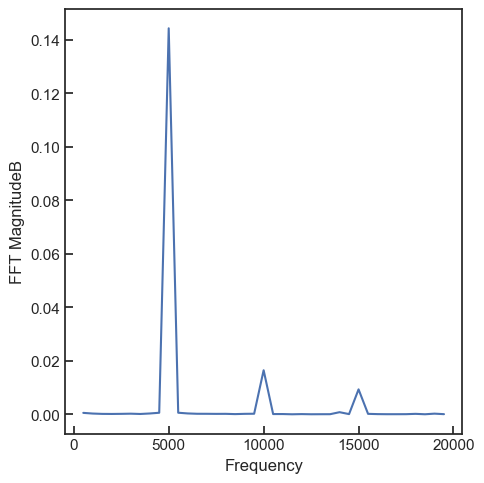

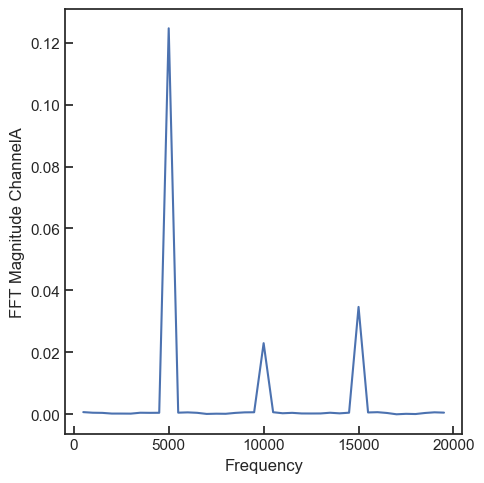

frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
frequency: 4999.999999999999 gain:  0.9510799999999999
       Frequency  Phase Angle Channel A  Phase Angle Channel B  Amplitude A  \
0      10.002484              61.759035             240.867817     0.001376   
1      10.002484              88.781813             328.896836     0.001286   
2      10.002484             331.272191             211.097874     0.001512   
3      10.002484        

C:\Users\khperera\Anaconda3\envs\Pandas\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\khperera\Anaconda3\envs\Pandas\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
C:\Users\khperera\Anaconda3\envs\Pandas\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\khperera\Anaconda3\envs\Pandas\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
C:\Users\khperera\Anaconda3\envs\Pandas\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\khperera\Anaconda3\envs\Pandas\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nan

{'openUnit': 1, 'setChA': 1, 'setChB': 1, 'sigGen': 1, 'trigger': 1, 'getTimebase': 1, 'runBlock': 1, 'isReady': 1, 'getValues': 3126, 'stop': 1, 'close': 1}


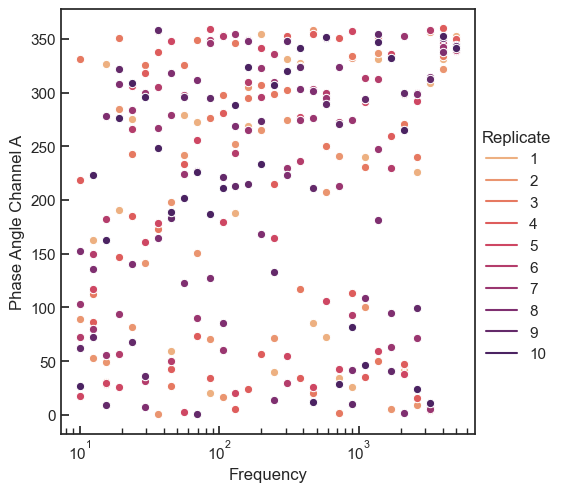

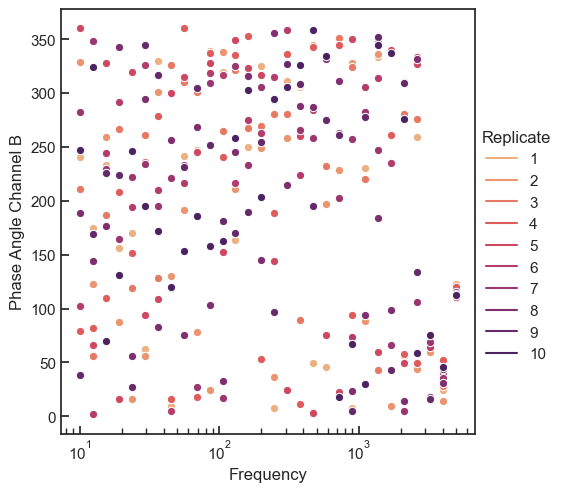

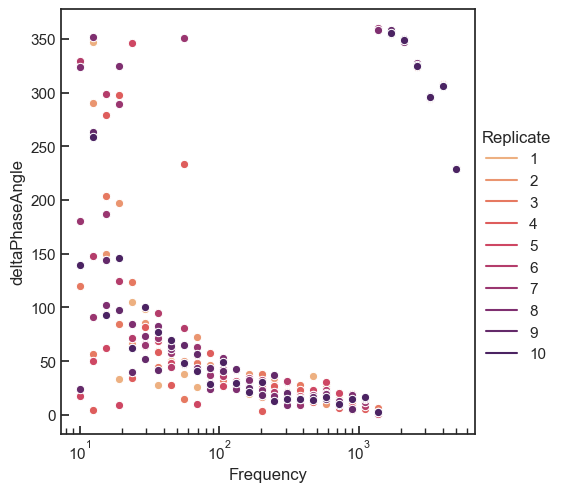

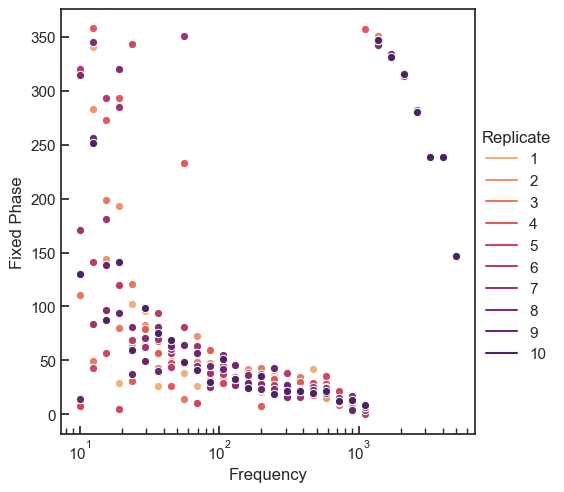

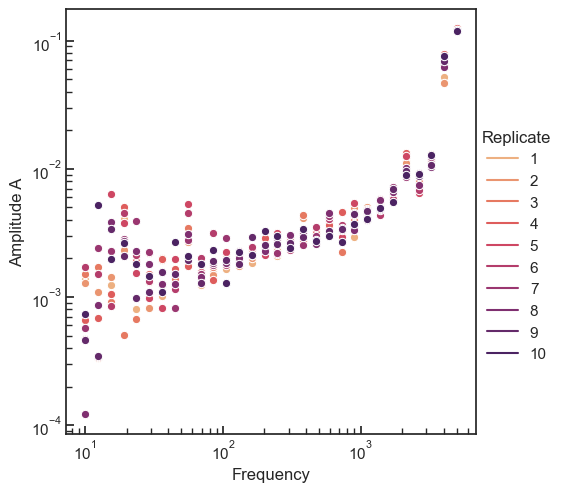

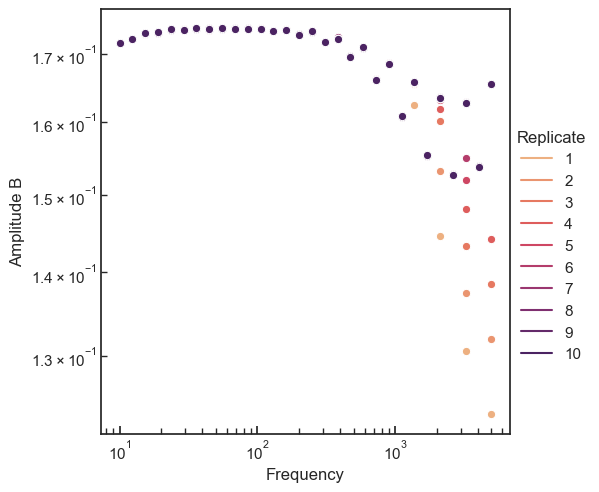

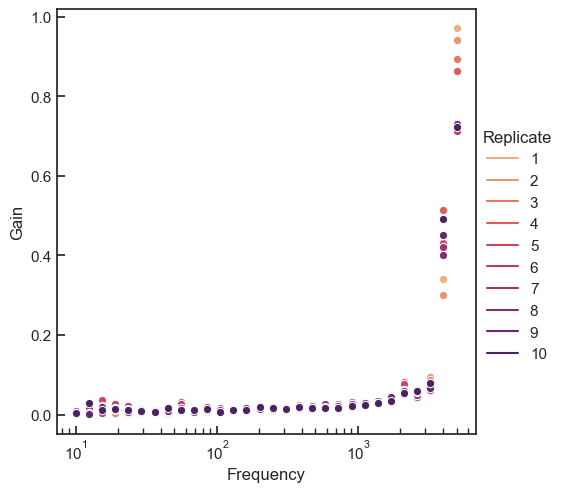

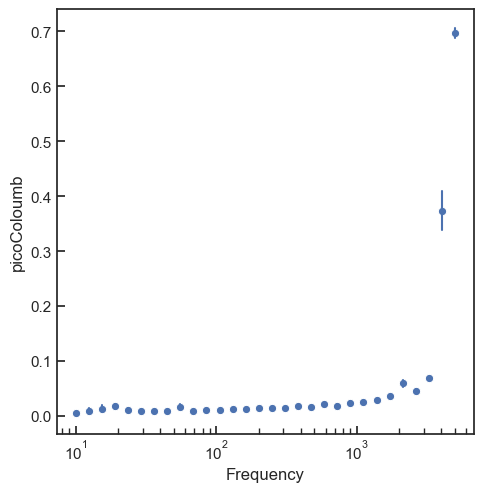

In [14]:
try:
    
    #location of calibration files
    ChargeAmplifierCalibration = "./CalibrationFiles/ChargeampCalibration0.1hzto10000-2.csv"
    EddyCurrentCalibration = "./CalibrationFiles/BigEddyCalibration.csv"
    TotalPhaseCalibration = "./CalibrationFiles/FullAmptoCharge_SideA_cap.csv"
    #PicoC/MU, MU/Volt
    ChargeAmplifierSettings  = [0.1,10]
    #gap height, mm
    GapHeight = 1
    
    
    zeo1 = Rheometer("goobiewoobie",ChargeAmplifierCalibration,EddyCurrentCalibration,ChargeAmplifierSettings,GapHeight,TotalPhaseCalibration)
    
    
    
    
    
    
    
    #filename1 = "PiezovsEddySensor_0.2v"
    #filename2 = "PiezovsEddySensor_0.1v"
    
    filename3 = "PDMS_wacker_final"
    
    Calibrate = False
    #PiezoVoltageChannel = [1,4]
    #startFrequency, endFrequency, divisions, amplitude, waveforms
    #amplitude in volts, waveform in integers, frequency in integers, divisions in integers, calibrate True/False    
    #zeo1.frequencySweep(10, 10000, 25, 0.2, 5,filename1,Calibrate)
    #Sensor = 
    #zeo1.frequencySweep(10, 10000, 25, 0.1, 5,file1ame2,Calibrate)
    StartVoltage = 1.5
    REMEMBER_TO_CHANGE_THE_VOTLAGE_BACK = 1
    howOftenToAutoVolt = 2
    
    

    

    
    amplitude = [0.05,0.1,0.15,0.2,0.25,0.3]
    
    #for amp in amplitude:
     #   finalFile = filename +str(amp)
     #   
    #    zeo1.frequencySweep(10, 10000, 500,amp,5,finalFile,Calibrate,StartVoltage,howOftenToAutoVolt)
        
    zeo1.frequencySweep(10, 5000, 30, 0.2 ,10,filename3,Calibrate,StartVoltage,howOftenToAutoVolt)
    

    zeo1.closeUnit()
    
except Exception as e:
    traceback.print_exc()
    print( "error", e)
    zeo1.closeUnit()

###### 

In [11]:
PiezoInterface = MicroController("piezo")

PiezoInterface.openUnit()

PiezoInterface.openChannels(4,4,0)

frequencies = [10,100,1000,10000]
dataForPlot = []

for j in frequencies:
    
    PiezoInterface.setSignalGenFreq(j,0.2,1.0)

    #calling in number of timebases
    data = PiezoInterface.measure(5)
    dataForPlot.append(data)
    
PiezoInterface.closeUnit()

PiezoInterface.printStatus()

# plot data from channel A and B

for a in dataForPlot:
    plt.plot(a[0], a[2][:])
    plt.plot(a[0], a[1][:])
#plt.plot(time, adc2mVChB[:])
    plt.xlabel('Time (ns)')
    plt.ylabel('Voltage (mV)')
    plt.show()

{'openUnit': 1, 'setChA': 1, 'setChB': 1, 'sigGen': 1, 'trigger': 1, 'getTimebase': 1, 'runBlock': 1, 'isReady': 1, 'getValues': 3125, 'stop': 1, 'close': 1}


IndexError: list index out of range

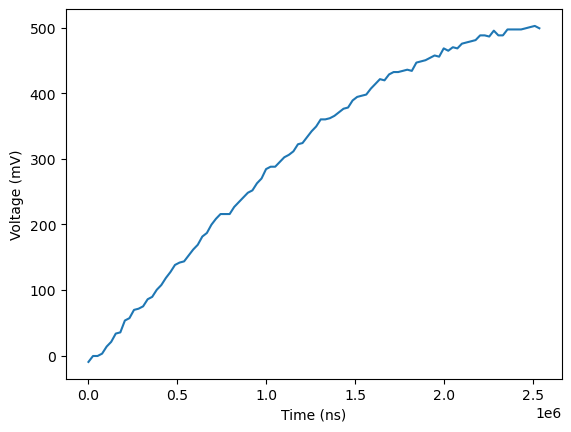

{'openUnit': 1, 'setChA': 1, 'setChB': 1, 'sigGen': 1, 'trigger': 1, 'getTimebase': 1, 'runBlock': 1, 'isReady': 1, 'getValues': 100, 'stop': 1, 'close': 1}


In [11]:
#
# Copyright (C) 2018 Pico Technology Ltd. See LICENSE file for terms.
#
# PS2000 BLOCK MODE EXAMPLE
# This example opens a 2000 driver device, sets up two channels and a trigger then collects a block of data.
# This data is then plotted as mV against time in ns.

import ctypes
import numpy as np
from picosdk.ps2000 import ps2000 as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico2000_ok

# Create status ready for use
status = {}

# Open 2000 series PicoScope
# Returns handle to chandle for use in future API functions
status["openUnit"] = ps.ps2000_open_unit()
assert_pico2000_ok(status["openUnit"])

# Create chandle for use
chandle = ctypes.c_int16(status["openUnit"])

# Set up channel A
# handle = chandle
# channel = PS2000_CHANNEL_A = 0
# enabled = 1
# coupling type = PS2000_DC = 1
# range = PS2000_2V = 7
# analogue offset = 0 V
chARange = 7
status["setChA"] = ps.ps2000_set_channel(chandle, 0, 1, 1, chARange)
assert_pico2000_ok(status["setChA"])

# Set up channel B
# handle = chandle
# channel = PS2000_CHANNEL_B = 1
# enabled = 1
# coupling type = PS2000_DC = 1
# range = PS2000_2V = 7
# analogue offset = 0 V
chBRange = 7
status["setChB"] = ps.ps2000_set_channel(chandle, 1, 0, 1, chBRange)
assert_pico2000_ok(status["setChB"])









#Generating singal to be measured


#Initializationvalues
offsetV = ctypes.c_int32(0) #microV
peaktopeakV = ctypes.c_uint32(1000000) #microV
StartFrequency = 100 
StopFrequency = 100
increment = 0 #0
dwell_time = 1
sweepType = 0

sweeps = ctypes.c_uint32(1)

status["sigGen"] = ps.ps2000_set_sig_gen_built_in(chandle, offsetV, peaktopeakV, 0, StartFrequency, StopFrequency, increment, dwell_time, sweepType, sweeps)
assert_pico2000_ok(status["setChB"])























# Set up single trigger
# handle = chandle
# source = PS2000_CHANNEL_A = 0
# threshold = 1024 ADC counts
# direction = PS2000_RISING = 0
# delay = 0 s
# auto Trigger = 1000 ms, basically the oscilloscope will measure in this amount of time.
status["trigger"] = ps.ps2000_set_trigger(chandle, 0, 64, 0, 0, 1000)
assert_pico2000_ok(status["trigger"])

# Set number of pre and post trigger samples to be collected
totalsamples = 1000
oversample1 = 10
preTriggerSamples = 0
postTriggerSamples = int(totalsamples/(oversample1))
maxSamples = preTriggerSamples + postTriggerSamples

# Get timebase information
# WARNING: When using this example it may not be possible to access all Timebases as all channels are enabled by default when opening the scope.  
# To access these Timebases, set any unused analogue channels to off.
# handle = chandle
# timebase = 8 = timebase
# no_of_samples = maxSamples
# pointer to time_interval = ctypes.byref(timeInterval)
# pointer to time_units = ctypes.byref(timeUnits)
# oversample = 1 = oversample
# pointer to max_samples = ctypes.byref(maxSamplesReturn)
timebase = 8
timeInterval = ctypes.c_int32()
timeUnits = ctypes.c_int32()
oversample = ctypes.c_int16(oversample1)
maxSamplesReturn = ctypes.c_int32()
status["getTimebase"] = ps.ps2000_get_timebase(chandle, timebase, maxSamples, ctypes.byref(timeInterval), ctypes.byref(timeUnits), oversample, ctypes.byref(maxSamplesReturn))
assert_pico2000_ok(status["getTimebase"])

# Run block capture
# handle = chandle
# no_of_samples = maxSamples
# timebase = timebase
# oversample = oversample
# pointer to time_indisposed_ms = ctypes.byref(timeIndisposedms)
timeIndisposedms = ctypes.c_int32()
status["runBlock"] = ps.ps2000_run_block(chandle, maxSamples, timebase, oversample, ctypes.byref(timeIndisposedms))
assert_pico2000_ok(status["runBlock"])

# Check for data collection to finish using ps5000aIsReady
ready = ctypes.c_int16(0)
check = ctypes.c_int16(0)
while ready.value == check.value:
    status["isReady"] = ps.ps2000_ready(chandle)
    ready = ctypes.c_int16(status["isReady"])

# Create buffers ready for data
bufferA = (ctypes.c_int16 * maxSamples)()
bufferB = (ctypes.c_int16 * maxSamples)()

# Get data from scope
# handle = chandle
# pointer to buffer_a = ctypes.byref(bufferA)
# pointer to buffer_b = ctypes.byref(bufferB)
# poiner to overflow = ctypes.byref(oversample)
# no_of_values = cmaxSamples
cmaxSamples = ctypes.c_int32(maxSamples)
status["getValues"] = ps.ps2000_get_values(chandle, ctypes.byref(bufferA), ctypes.byref(bufferB), None, None, ctypes.byref(oversample), cmaxSamples)
assert_pico2000_ok(status["getValues"])

# find maximum ADC count value
maxADC = ctypes.c_int16(32767)

# convert ADC counts data to mV
adc2mVChA =  adc2mV(bufferA, chARange, maxADC)
adc2mVChB =  adc2mV(bufferB, chBRange, maxADC)

# Create time data
time = np.linspace(0, (cmaxSamples.value -1) * timeInterval.value, cmaxSamples.value)

# plot data from channel A and B
plt.plot(time, adc2mVChA[:])
#plt.plot(time, adc2mVChB[:])
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (mV)')
plt.show()

# Stop the scope
# handle = chandle
status["stop"] = ps.ps2000_stop(chandle)
assert_pico2000_ok(status["stop"])

# Close unitDisconnect the scope
# handle = chandle
status["close"] = ps.ps2000_close_unit(chandle)
assert_pico2000_ok(status["close"])

# display status returns
print(status)


In [3]:

#values to pass to function
frequency = 10000
oversample2 = 1
waveforms = 10
time_elapsed = waveforms/frequency
numberofsamples = time_elapsed/(2e-8)/oversample2/100
print(numberofsamples)

#Generating singal to be measured





setSignalGenFreq(frequency)






















# Set up single trigger
# handle = chandle
# source = PS2000_CHANNEL_A = 0
# threshold = 1024 ADC counts
# direction = PS2000_RISING = 0
# delay = 0 s
# auto Trigger = 1000 ms, basically the oscilloscope will measure in this amount of time.
status["trigger"] = ps.ps2000_set_trigger(chandle, 0, 64, 0, 0, 1000)
assert_pico2000_ok(status["trigger"])

# Set number of pre and post trigger samples to be collected
totalsamples = numberofsamples
oversample1 = oversample2

preTriggerSamples = 0
postTriggerSamples = int(totalsamples/oversample1)
maxSamples = preTriggerSamples + postTriggerSamples

# Get timebase information
# WARNING: When using this example it may not be possible to access all Timebases as all channels are enabled by default when opening the scope.  
# To access these Timebases, set any unused analogue channels to off.
# handle = chandle
# timebase = 8 = timebase
# no_of_samples = maxSamples
# pointer to time_interval = ctypes.byref(timeInterval)
# pointer to time_units = ctypes.byref(timeUnits)
# oversample = 1 = oversample
# pointer to max_samples = ctypes.byref(maxSamplesReturn)
timebase = 8
timeInterval = ctypes.c_int32()
timeUnits = ctypes.c_int32()
oversample = ctypes.c_int16(oversample1)
maxSamplesReturn = ctypes.c_int32()
status["getTimebase"] = ps.ps2000_get_timebase(chandle, timebase, maxSamples, ctypes.byref(timeInterval), ctypes.byref(timeUnits), oversample, ctypes.byref(maxSamplesReturn))
assert_pico2000_ok(status["getTimebase"])

# Run block capture
# handle = chandle
# no_of_samples = maxSamples
# timebase = timebase
# oversample = oversample
# pointer to time_indisposed_ms = ctypes.byref(timeIndisposedms)
timeIndisposedms = ctypes.c_int32()
status["runBlock"] = ps.ps2000_run_block(chandle, maxSamples, timebase, oversample, ctypes.byref(timeIndisposedms))
assert_pico2000_ok(status["runBlock"])

# Check for data collection to finish using ps5000aIsReady
ready = ctypes.c_int16(0)
check = ctypes.c_int16(0)
while ready.value == check.value:
    status["isReady"] = ps.ps2000_ready(chandle)
    ready = ctypes.c_int16(status["isReady"])

# Create buffers ready for data
bufferA = (ctypes.c_int16 * maxSamples)()
bufferB = (ctypes.c_int16 * maxSamples)()

# Get data from scope
# handle = chandle
# pointer to buffer_a = ctypes.byref(bufferA)
# pointer to buffer_b = ctypes.byref(bufferB)
# poiner to overflow = ctypes.byref(oversample)
# no_of_values = cmaxSamples
cmaxSamples = ctypes.c_int32(maxSamples)
status["getValues"] = ps.ps2000_get_values(chandle, ctypes.byref(bufferA), ctypes.byref(bufferB), None, None, ctypes.byref(oversample), cmaxSamples)
assert_pico2000_ok(status["getValues"])

# find maximum ADC count value
maxADC = ctypes.c_int16(32767)

# convert ADC counts data to mV
adc2mVChA =  adc2mV(bufferA, chARange, maxADC)
adc2mVChB =  adc2mV(bufferB, chBRange, maxADC)

# Create time data
time = np.linspace(0, (cmaxSamples.value -1) * timeInterval.value, cmaxSamples.value)

# plot data from channel A and B
plt.plot(time, adc2mVChA[:])
#plt.plot(time, adc2mVChB[:])
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (mV)')
plt.show()

# Stop the scope
# handle = chandle
status["stop"] = ps.ps2000_stop(chandle)
assert_pico2000_ok(status["stop"])

# Close unitDisconnect the scope
# handle = chandle
status["close"] = ps.ps2000_close_unit(chandle)
assert_pico2000_ok(status["close"])

# display status returns
print(status)

500.0


NameError: name 'setSignalGenFreq' is not defined

     Unnamed: 0     Frequency  Phase Angle Channel A  Phase Angle Channel B  \
0             0     10.002484              67.497667             152.887847   
1             1     10.002484             122.580253             207.379429   
2             2     10.002484             269.688078             354.659658   
3             3     10.722972             332.061577              61.191701   
4             4     10.722972             317.846377              46.662559   
..          ...           ...                    ...                    ...   
295         295   9328.358209              75.453028             309.971542   
296         296   9328.358209             275.382828             149.901822   
297         297  10003.201024             225.262959             103.705608   
298         298  10003.201024             193.342864              72.269610   
299         299  10003.201024             192.650189              71.489392   

     Amplitude A  Amplitude B  Replicate  deltaPhas

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1566303445.py:52: RuntimeWarning: divide by zero encountered in log10
  ActualData["LogFreq"] = np.log10(ActualData.index)


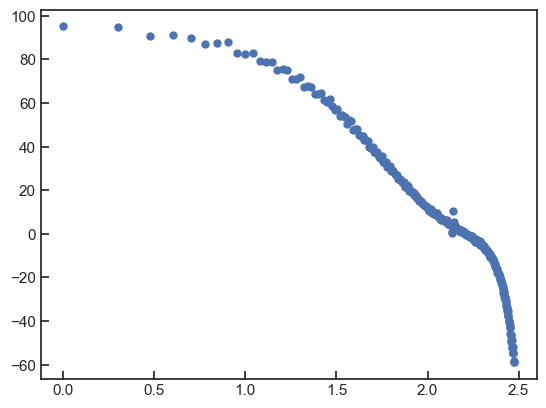

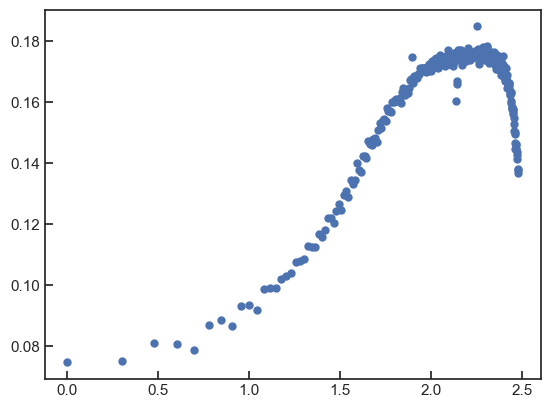

      Unnamed: 0     Frequency  Phase Angle Channel A  Phase Angle Channel B  \
0              0      5.001242               1.455291              31.012546   
1              1      5.001242              25.420055              54.780354   
2              2      5.001242             316.337482             346.793076   
3              3      5.077800             121.549909             152.537664   
4              4      5.077800             167.996600             197.870273   
...          ...           ...                    ...                    ...   
1495        1495   9851.828499             353.494013              79.199735   
1496        1496   9851.828499             354.394889              78.957678   
1497        1497  10003.201024             357.788449              84.811544   
1498        1498  10003.201024             349.592862              74.216655   
1499        1499  10003.201024             353.694866              77.683079   

      Amplitude A  Amplitude B  Replica

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1566303445.py:52: RuntimeWarning: divide by zero encountered in log10
  ActualData["LogFreq"] = np.log10(ActualData.index)


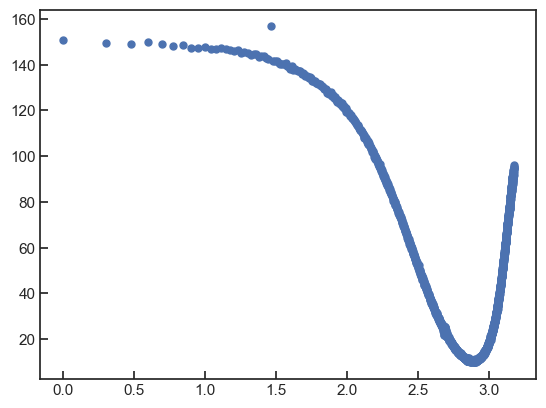

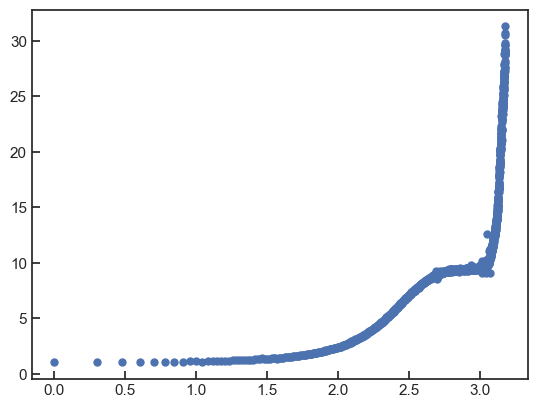

C:\Users\khperera\AppData\Local\Temp\ipykernel_6992\1566303445.py:106: RuntimeWarning: divide by zero encountered in log10
  ActualData["LogFreq"] = np.log10(ActualData.index)


C:/Users/khperera/Documents/GraphOutput/PDMS_wacker_final.csv
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
295   NaN
296   NaN
297   NaN
298   NaN
299   NaN
Name: Fixed Phase, Length: 300, dtype: float64


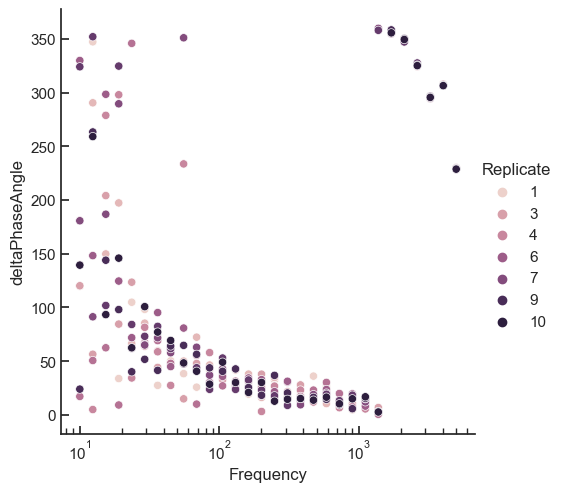

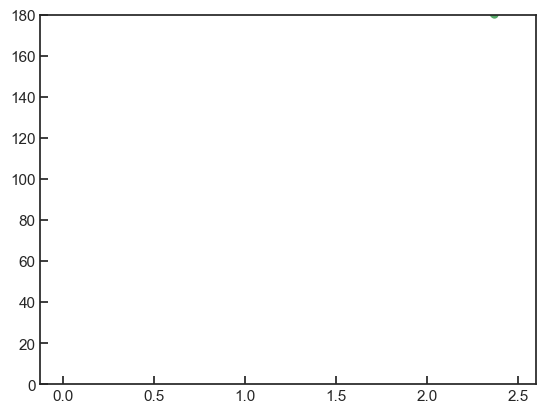

In [33]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

TotalSystemResponse = "C:/Users/khperera/Documents/GraphOutput/10pFCap1mOhmresiChargeAmplCali.csv"
CapResponse = "C:/Users/khperera/Documents/GraphOutput/Calibration-10pC-1MOhm.csv"
#UpstreamCalibration =  "C:/Users/khperera/Documents/GraphOutput/BigEddyCalibration.csv"
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 1.5)
    upper_limit = s.mean() + (s.std() * 1.5)
    return ~s.between(lower_limit, upper_limit)



#SiliOil12PaS = "C:/Users/khperera/Documents/GraphOutput/siliOil12PaS.csv"
#Wacker1000 = "C:/Users/khperera/Documents/GraphOutput_TO7-12/BASELINE_ERROR_NEWCHARGEAMP_FARADAYCAGE_wacker1000.csv"


#NewPDMS = "C:/Users/khperera/Documents/GraphOutput/PDMS_sideB.csv"
PDMS = "C:/Users/khperera/Documents/GraphOutput/PDMS_wacker_final.csv"





# Choose the right order for your spline. 1 is linear, 2 is quadratic, 3 is cubic, etc.
spline_order =2
spline_order1 =2
spline_order3 = 2
# s is a smoothing factor. The smaller, the smoother.
s = 500
s1 = 1000
s3 = 100





#splinte, smoothing factor, order
def generateSplines(location,spline_order,s,fix,splineRatio):    
    
    ActualData = pd.read_csv(location)
    print(ActualData)
    if fix>0:
        ActualData['deltaPhaseAngle3'] = ActualData['deltaPhaseAngle'] - fix
    else:
        ActualData['deltaPhaseAngle3'] = ActualData['deltaPhaseAngle'].apply(lambda x: x - 360 if x > 180 else x)  
    #ActualData = ActualData[~ActualData.groupby('Frequency')['deltaPhaseAngle'].apply(is_outlier)]
    ActualData = ActualData.groupby("Frequency").mean()
    ActualData["LogFreq"] = np.log10(ActualData.index)
    ActualData["DeltaReal"] = (ActualData["Phase Angle Channel B"]%360-ActualData["Phase Angle Channel A"]%360)%360

    splinePhase = UnivariateSpline(ActualData["LogFreq"], ActualData["deltaPhaseAngle3"], k=spline_order, s=s)
    output = splinePhase(ActualData["LogFreq"])
    
    
    
    splineGain = UnivariateSpline(ActualData["LogFreq"], ActualData["Gain"], k=spline_order, s=splineRatio)
    outputGain = splineGain(ActualData["LogFreq"])
    
    
    plt.show()
    print(location)
    plt.figure()
    #plt.plot(ActualData["LogFreq"],ActualData["GainFix"], 'ro', ms=5) # original data in red
    plt.plot(ActualData["LogFreq"],ActualData["deltaPhaseAngle3"], 'bo', ms=5) # original data in red
    #plt.plot(ActualData["LogFreq"],ActualData["DeltaReal"], 'go', ms=5) # original data in blue
    plt.plot(ActualData["LogFreq"],output, 'r', ms=5) # original data in red
    #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel B"], 'bo', ms=5) # original data in blue
    
    
    #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel A"], 'go', ms=5) # original data in blue
    
    
    #plt.plot(np.array(Dataframe31.index), newChargeAmp, 'b', lw=3) # spline fit in blue
    plt.show()
    plt.figure()
    #plt.plot(ActualData["LogFreq"],ActualData["GainFix"], 'ro', ms=5) # original data in red
    plt.plot(ActualData["LogFreq"],ActualData["Gain"], 'bo', ms=5) # original data in red
    plt.plot(ActualData["LogFreq"],outputGain, 'g', ms=5) # original data in red
    
    #plt.plot(ActualData["LogFreq"],ActualData["DeltaReal"], 'go', ms=5) # original data in blue
    #plt.plot(ActualData["LogFreq"],output, 'r', ms=5) # original data in red
    #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel B"], 'bo', ms=5) # original data in blue

    
    #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel A"], 'go', ms=5) # original data in blue
    
    
    #plt.plot(np.array(Dataframe31.index), newChargeAmp, 'b', lw=3) # spline fit in blue
    plt.show()
    
    
    return (splinePhase,splineGain)




def graphFrequency(location, splineChargeAmp, splinePhase, splinePhase2):
    ActualData = pd.read_csv(location)
    #ActualData = ActualData.groupby("Frequency").mean()
    #print(ActualData)
    
    ActualData["LogFreq"] = np.log10(ActualData.index)
    ActualData["DownstreamCorrection"] = splinePhase2(ActualData["LogFreq"])
    ActualData["UpstreamPhaseCorrection"] =   splinePhase(ActualData["LogFreq"])
    ActualData["PhaseCorrection"] = -ActualData["DownstreamCorrection"] + ActualData["UpstreamPhaseCorrection"] + 90
    
    ActualData["deltaPhaseAngle"]= (ActualData["deltaPhaseAngle"])
    
    ActualData = ActualData[~ActualData.groupby('Frequency')['deltaPhaseAngle'].apply(is_outlier)]
    

    thing = sns.relplot(data = ActualData, x = "Frequency", y = "deltaPhaseAngle", hue = "Replicate")
    thing.set(xscale="log")
    
    
    #ActualData["Phase B Corrected"] =  ActualData["Phase Angle Channel B"] - ActualData["PhaseCorrection"] - 180
    
    #ActualData["PhaseActual"] = (ActualData["Phase B Corrected"] - ActualData["Phase Angle Channel A"]-180)%360
    
    #ActualData["GainFix"] =   splineGain(ActualData["LogFreq"])/splineGain(ActualData["LogFreq"]).max()
    ActualData["Fixed Phase"] = (ActualData["deltaPhaseAngle"]%180-ActualData["DownstreamCorrection"])%360
    #ActualData["Fixed Phase"] = np.abs(ActualData["Fixed Phase"] - 360)
    #ActualData["Fixed Phase2"] = (ActualData["deltaPhase"]- ActualData["PhaseCorrection"])%360
    #ActualData["FixedGain"] = ActualData["Gain"] /ActualData["GainFix"] 
    
    
    
    
    
    
    print(location)
    
    #plt.figure()
    #plt.plot(ActualData["LogFreq"],ActualData["GainFix"], 'ro', ms=5) # original data in red
    #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel A"], 'ro', ms=5) # original data in red
    #plt.plot(ActualData["LogFreq"],ActualData["Phase Angle Channel B"], 'bo', ms=5) # original data in blue
    
    #plt.plot(ActualData["LogFreq"],ActualData["deltaPhase"], 'g', ms=5) # original data in red
    #plt.plot(ActualData["LogFreq"],ActualData["deltaPhaseAngle"], 'orange', ms=5) # original data in blue
    
    #plt.plot(np.array(Dataframe31.index), newChargeAmp, 'b', lw=3) # spline fit in blue
    #plt.show()
    print(ActualData["Fixed Phase"])
    plt.figure()
    #plt.plot(ActualData["LogFreq"],ActualData["GainFix"], 'ro', ms=5) # original data in red
    plt.plot(ActualData["LogFreq"],ActualData["DownstreamCorrection"], 'bo', ms=5) # original data in red
    plt.plot(ActualData["LogFreq"],ActualData["Fixed Phase"], 'r', ms=5) # original data in blue
    plt.plot(ActualData["LogFreq"],ActualData["deltaPhaseAngle"] + 180, 'go', ms=5) # original data in blue
    #plt.plot(ActualData["LogFreq"],ActualData["UpstreamPhaseCorrection"], 'orange', ms=5) # original data in blue
    #plt.plot(ActualData["LogFreq"],ActualData["DownstreamCorrection"], 'purple', ms=5) # original data in blue
    plt.ylim([0, 180])
    
    
    #plt.plot(ActualData["LogFreq"],ActualData["DownstreamSpline"], 'bo', ms=5) # original data in blue
    #plt.plot(ActualData["LogFreq"],ActualData["UpstreamPhaseCorrection"], 'go', ms=5) # original data in blue
    #plt.plot(ActualData["LogFreq"],ActualData["Phase Correction"], 'ro', ms=5) # original data in blue
     
    #plt.plot(np.array(Dataframe31.index), newChargeAmp, 'b', lw=3) # spline fit in blue
    plt.show()
    
    return ActualData
    
TotalSpline= generateSplines(TotalSystemResponse, 2,0.01,180,0.001)  
CapSpline1 = generateSplines(CapResponse, 2,10,180,0.1)  
 
#DownstreamSpline = DownstreamSpline1[0]
#UpstreamSpline = UpstreamSpline1[0]

TotalResponse = graphFrequency(PDMS,TotalSpline[1],TotalSpline[0],CapSpline1[0])

#siliOil = graphFrequency(NewSilicon,splineGain,UpstreamSpline,DownstreamSpline)
#siliOil2 = graphFrequency(Wacker1000,UpstreamSpline1[1],UpstreamSpline,DownstreamSpline)
#siliOil3 = graphFrequency(NewSilicon3,splineGain,UpstreamSpline,DownstreamSpline)
#siliOil3 = graphFrequency(NewSilicon3,splineGain,UpstreamSpline,DownstreamSpline)

#air1 = graphFrequency(air,splineGain,UpstreamSpline,DownstreamSpline)
#siliOil["Friend"]=siliOil["Phase Angle Channel A"]-siliOil["Raw Phase A"]
#print(siliOil)
#siliOil2["Difference"] =  (-pdms2["deltaPhase"] +siliOil2["deltaPhase"])
#siliOil3["Difference"] =  (-pdms2["deltaPhase"] +siliOil3["deltaPhase"])


 
#siliOil2["G'"] =  siliOil2["Amplitude A"]
#siliOil2["G''"] = siliOil2["Amplitude A"]*np.tan(siliOil2["Difference"]/180*3.14)
#siliOil["Difference2"] = (siliOil["Amplitude B"]/ siliOil2["Amplitude B"])
#pdms["Difference"] = (-1*pdms["Raw Phase B"] +pdms2["Raw Phase B"])


#print(siliOil["Difference"])
#print("Plot difference")
#print(siliOil2)
#plt.plot(ActualData["LogFreq"],ActualData["GainFix"], 'ro', ms=5) # original data in red
#plt.plot(siliOil2["LogFreq"],siliOil2["Difference"], 'bo', ms=5, label = "12 Pas") # original data in red
#plt.plot(siliOil2["LogFreq"],siliOil3["Difference"], 'ro', ms=5, label = "1000 Pas") # original data in red

#plt.plot(siliOil2["LogFreq"],siliOil2["G'"], 'bo', ms=5) # original data in red
#plt.plot(siliOil2["LogFreq"],siliOil2["G''"], 'go', ms=5) # original data in red



#plt.ylim([50, 220])
#plt.plot(pdms["LogFreq"],pdms["Difference"], 'go', ms=5) # original data in red

#plt.plot(pdms["LogFreq"],pdms["Fixed Phase"], 'ro', ms=5) # original data in red
#plt.plot(air1["LogFreq"],air1["Fixed Phase"], 'go', ms=5) # original data in red
#plt.plot(ActualData["LogFreq"],ActualData["DownstreamSpline"], 'bo', ms=5) # original data in blue
#plt.plot(ActualData["LogFreq"],ActualData["UpstreamPhaseCorrection"], 'go', ms=5) # original data in blue
#plt.plot(ActualData["LogFreq"],ActualData["Phase Correction"], 'ro', ms=5) # original data in blue
#plt.legend()
#plt.ylim([-5, 100])
#plt.plot(np.array(Dataframe31.index), newChargeAmp, 'b', lw=3) # spline fit in blue
#plt.show()

[1.30113785 1.32830387 1.35566636 1.38297482 1.41009935 1.43746999
 1.46481083 1.49188611 1.51923075 1.54640576 1.57365898 1.60103058
 1.62827443 1.65556811 1.68280345 1.7100331  1.73733253 1.76459762
 1.79181327 1.81908634 1.84631047 1.87362387 1.90092628 1.92809679
 1.95547278 1.98263539 2.00996961 2.0371982  2.06438795 2.09174323
 2.1189451  2.1462181  2.17345874 2.20082493 2.22807286 2.25522025
 2.2826411  2.30990887 2.33706698 2.36438759 2.3915664  2.41880701
 2.44612862 2.47342916 2.50058567 2.52790149 2.55513114 2.58247915
 2.6096698  2.63693885 2.66418438 2.69150218 2.71867205 2.74604202
 2.77327021 2.80049055 2.82773343 2.8550449  2.88232046 2.90961496
 2.93681381 2.96418937 2.9914407  3.01865625 3.04583471 3.07311451
 3.10039834 3.12771783 3.15496152 3.18216502 3.20956282 3.23669183
 3.26399254 3.29138197 3.3185272  3.34575413 3.37309326 3.40030902
 3.42755594 3.45488099 3.48218149 3.50933373 3.5365729  3.56400283
 3.59110908 3.61840123 3.64567639 3.67294364 3.70022258 3.7273

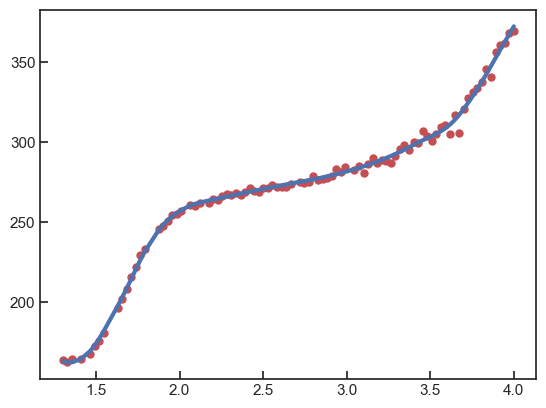

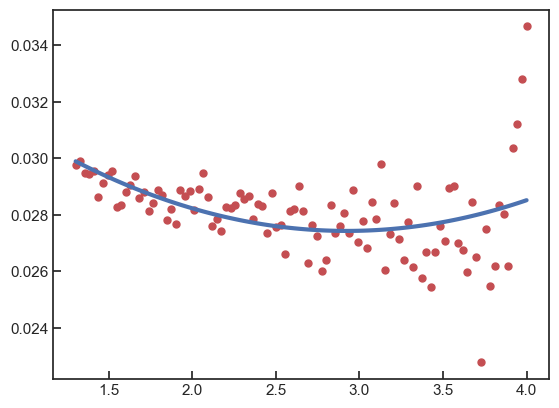

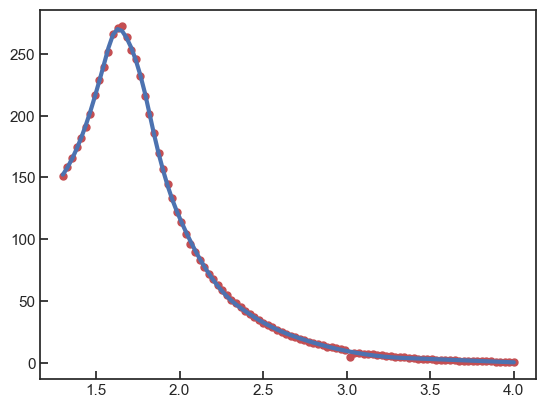

              Unnamed: 0  Phase Angle Channel A  Phase Angle Channel B  \
Frequency                                                                
20.004968            1.5             326.073235              91.977282   
21.296286            5.5             322.817977               2.359498   
22.681217            9.5             319.872805              91.875342   
24.153208           13.5             317.445646               2.624474   
25.709838           17.5             315.236652               3.128516   
...                  ...                    ...                    ...   
7781.374502        381.5             104.057372             267.199985   
8284.729586        385.5              64.866228             358.019486   
8820.208863        389.5              89.532804               2.262830   
9392.846408        393.5              84.588623               6.531889   
10003.201024       397.5             353.767418              11.726567   

              Amplitude A  Amplitude 

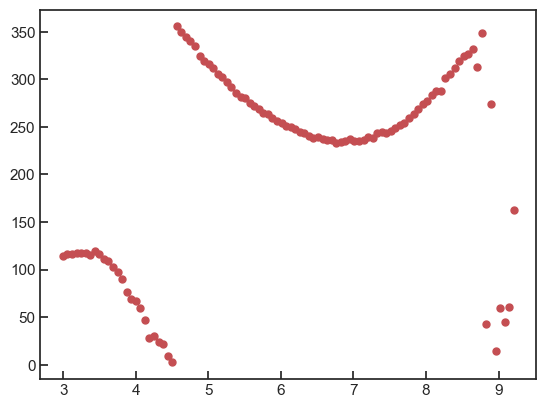

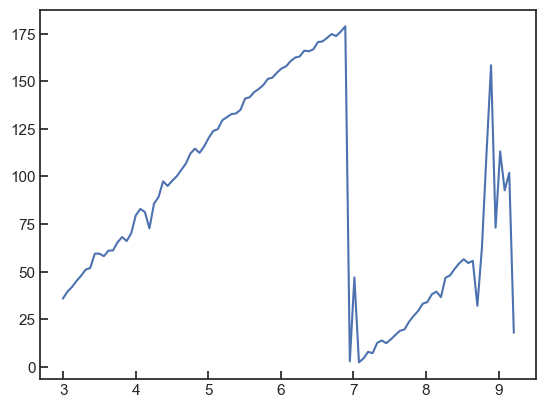

In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Wacker1000_1mm = "C:/Users/khperera/Documents/GraphOutput/Wacker-1000-1mm-flipped.csv"
